# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

# Import note: The classroom currently uses sklearn version 0.19.
# If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
# instead of sklearn.impute as in newer versions of sklearn.

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# Printing the number of rows and columns
azdias.shape

(891221, 85)

In [5]:
# Printing the first few rows
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [100]:
# Printing the number of rows and columns
feat_info.shape

(85, 4)

In [101]:
# Printing the first few rows
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [102]:
### Identify missing or unknown data values and convert them to NaNs.

# Number of missing values by column
original_missing_columns = azdias.isnull().sum()
original_missing_columns.sort_values(ascending=False)

KK_KUNDENTYP             584612
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
KBA05_ANTG4              133324
KBA05_BAUMAX             133324
KBA05_GBZ                133324
MOBI_REGIO               133324
REGIOTYP                 121196
KKK                      121196
PLZ8_ANTG3               116515
PLZ8_ANTG1               116515
PLZ8_GBZ                 116515
PLZ8_ANTG2               116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
W_KEIT_KIND_HH           107602
KBA13_ANZAHL_PKW         105800
CAMEO_INTL_2015           98979
CAMEO_DEU_2015            98979
CAMEO_DEUG_2015           98979
ORTSGR_KLS9               97216
ARBEIT                    97216
RELAT_AB                  97216
ANZ_HH_TITEL              97008
BALLRAUM                  93740
EWDICHTE                  93740
INNENSTADT                93740
GEBAEUDETYP_RASTER        93155
                          ...  
FINANZ_H

In [103]:
### Getting the total of missing values
original_missing = original_missing_columns.sum()
original_missing

4896838

In [104]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [105]:
### Creating columns for missing values
feat_info2 = feat_info.copy()
feat_info2['missing_or_unknown'] = feat_info2['missing_or_unknown'].str.replace('[', '').str.replace(']', '')
feat_info2

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"-1,0"
1,ALTERSKATEGORIE_GROB,person,ordinal,"-1,0,9"
2,ANREDE_KZ,person,categorical,"-1,0"
3,CJT_GESAMTTYP,person,categorical,0
4,FINANZ_MINIMALIST,person,ordinal,-1
5,FINANZ_SPARER,person,ordinal,-1
6,FINANZ_VORSORGER,person,ordinal,-1
7,FINANZ_ANLEGER,person,ordinal,-1
8,FINANZ_UNAUFFAELLIGER,person,ordinal,-1
9,FINANZ_HAUSBAUER,person,ordinal,-1


In [106]:
# Creating separate columns for each missing or unknown value
feat_info2[['m_or_u1', 'm_or_u2', 'm_or_u3']] = feat_info2.missing_or_unknown.str.split(',', expand=True)
feat_info3 = feat_info2[['attribute', 'm_or_u1', 'm_or_u2', 'm_or_u3']]
feat_info3

,attribute,m_or_u1,m_or_u2,m_or_u3
0,AGER_TYP,-1,0,None
1,ALTERSKATEGORIE_GROB,-1,0,9
2,ANREDE_KZ,-1,0,None
3,CJT_GESAMTTYP,0,None,None
4,FINANZ_MINIMALIST,-1,None,None
5,FINANZ_SPARER,-1,None,None
6,FINANZ_VORSORGER,-1,None,None
7,FINANZ_ANLEGER,-1,None,None
8,FINANZ_UNAUFFAELLIGER,-1,None,None
9,FINANZ_HAUSBAUER,-1,None,None


In [107]:
### Capturing attributes that contain X or XX and saving them to list
cols = ['m_or_u1', 'm_or_u2', 'm_or_u3']
replace = []

for i in cols:
    replace.append((feat_info3['attribute'][feat_info3[i].isin(['X', 'XX'])]).tolist())
    
attributes = []
for i in range(0, len(replace)):
    for j in range(0, len(replace[i])): 
        attributes.append(replace[i][j])
    
print(attributes)

['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015']


### First column

In [108]:
### First Column - distinct values
feat_info3['m_or_u1'].unique()

array(['-1', '0', '', 'XX'], dtype=object)

In [109]:
### Looking attributes that contain XX
feat_info3[feat_info3['m_or_u1'] == 'XX']

,attribute,m_or_u1,m_or_u2,m_or_u3
58,CAMEO_DEU_2015,XX,None,None


In [110]:
### Checking unique values before the replacement
azdias['CAMEO_DEU_2015'].unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C', 'XX'], dtype=object)

In [111]:
### Replacing XX in attribute
azdias['CAMEO_DEU_2015'] = azdias['CAMEO_DEU_2015'].str.replace('XX', '00')

In [112]:
### Checking unique values after the replacement
azdias['CAMEO_DEU_2015'].unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C', '00'], dtype=object)

### Second column

In [113]:
###Second colunm - distinct values
feat_info3['m_or_u2'].unique()

array(['0', None, '9', 'X', 'XX'], dtype=object)

In [114]:
### Looking for attributes that contain X in the second column
feat_info3[feat_info3['m_or_u2'] == 'X']

,attribute,m_or_u1,m_or_u2,m_or_u3
57,CAMEO_DEUG_2015,-1,X,None


In [115]:
### Checking unique values before the replacement
azdias['CAMEO_DEUG_2015'].unique()

array([nan, '8', '4', '2', '6', '1', '9', '5', '7', '3', 'X'], dtype=object)

In [116]:
### Replacing X in attribute 
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].str.replace('X', '0')

In [117]:
### Checking unique values after the replacement
azdias['CAMEO_DEUG_2015'].unique()

array([nan, '8', '4', '2', '6', '1', '9', '5', '7', '3', '0'], dtype=object)

In [118]:
### Looking for attributes that contain X in the second column 
feat_info3[feat_info3['m_or_u2'] == 'XX']

,attribute,m_or_u1,m_or_u2,m_or_u3
59,CAMEO_INTL_2015,-1,XX,None


In [119]:
### Checking unique values before the replacement
azdias['CAMEO_INTL_2015'].unique()

array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32',
       'XX'], dtype=object)

In [120]:
### Replacing XX in attribute
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].str.replace('XX', '00')

In [121]:
### Checking unique values after the replacement
azdias['CAMEO_INTL_2015'].unique()

array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32',
       '00'], dtype=object)

### Third column

In [122]:
### Third colunm - distinct values
feat_info3['m_or_u3'].unique()

array([None, '9'], dtype=object)

**Obs:** No need for replacement

In [123]:
### Replacing values in feat_info
feat_info4 = feat_info3.copy()
feat_info4['m_or_u1'] = feat_info4['m_or_u1'].str.replace('X', '0').str.replace('XX', '00')
feat_info4['m_or_u2'] = feat_info4['m_or_u2'].str.replace('X', '0').str.replace('XX', '00')
feat_info4.m_or_u1.fillna(value=np.nan, inplace=True)

In [124]:
feat_info4['m_or_u1'].unique()

array(['-1', '0', '', '00'], dtype=object)

In [125]:
feat_info4['m_or_u2'].unique()

array(['0', None, '9', '00'], dtype=object)

In [126]:
feat_info4['m_or_u3'].unique()

array([None, '9'], dtype=object)

In [127]:
### Transposing feat_info
feat_info4 = feat_info4.set_index('attribute').transpose()
feat_info4

attribute,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
m_or_u1,-1,-1,-1,0,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
m_or_u2,0,0,0,None,None,None,None,None,None,None,...,None,None,None,None,0,None,None,9,0,9
m_or_u3,None,9,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [128]:
### Checking unique values type before converting to float
feat_info4['AGER_TYP'].unique()

array(['-1', '0', None], dtype=object)

In [129]:
### Converting values to float in feat_info
for col in feat_info4.columns:
    try:
        feat_info4[col] = feat_info4[col].astype(float)
    except:
        continue

In [130]:
### Converting values to float in azdias
for col in azdias.columns:
    try:
        azdias[col] = azdias[col].astype(float)
    except:
        continue

In [131]:
### Checking unique value after converting to flow
feat_info4['AGER_TYP'].unique()

array([ -1.,   0.,  nan])

In [132]:
azdias['AGER_TYP'].unique()

array([-1.,  2.,  3.,  0.,  1.])

In [133]:
### Converting the DataFrame into a Dictionary
feat_info4_dict = feat_info4.to_dict(orient='list')
feat_info4_dict

{'AGER_TYP': [-1.0, 0.0, nan],
 'ALTERSKATEGORIE_GROB': [-1.0, 0.0, 9.0],
 'ANREDE_KZ': [-1.0, 0.0, nan],
 'CJT_GESAMTTYP': [0.0, nan, nan],
 'FINANZ_MINIMALIST': [-1.0, nan, nan],
 'FINANZ_SPARER': [-1.0, nan, nan],
 'FINANZ_VORSORGER': [-1.0, nan, nan],
 'FINANZ_ANLEGER': [-1.0, nan, nan],
 'FINANZ_UNAUFFAELLIGER': [-1.0, nan, nan],
 'FINANZ_HAUSBAUER': [-1.0, nan, nan],
 'FINANZTYP': [-1.0, nan, nan],
 'GEBURTSJAHR': [0.0, nan, nan],
 'GFK_URLAUBERTYP': ['', None, None],
 'GREEN_AVANTGARDE': ['', None, None],
 'HEALTH_TYP': [-1.0, 0.0, nan],
 'LP_LEBENSPHASE_FEIN': [0.0, nan, nan],
 'LP_LEBENSPHASE_GROB': [0.0, nan, nan],
 'LP_FAMILIE_FEIN': [0.0, nan, nan],
 'LP_FAMILIE_GROB': [0.0, nan, nan],
 'LP_STATUS_FEIN': [0.0, nan, nan],
 'LP_STATUS_GROB': [0.0, nan, nan],
 'NATIONALITAET_KZ': [-1.0, 0.0, nan],
 'PRAEGENDE_JUGENDJAHRE': [-1.0, 0.0, nan],
 'RETOURTYP_BK_S': [0.0, nan, nan],
 'SEMIO_SOZ': [-1.0, 9.0, nan],
 'SEMIO_FAM': [-1.0, 9.0, nan],
 'SEMIO_REL': [-1.0, 9.0, nan],
 'SEMI

In [134]:
### Replacing missing or unknown values
azdias.replace(feat_info4_dict, np.nan, inplace=True)

In [135]:
### Cheking data types for all attributes 
azdias.dtypes.value_counts()

float64    83
object      2
dtype: int64

In [136]:
### Checking the two columns that haven't been converted to float
azdias.select_dtypes('object').head()

,OST_WEST_KZ,CAMEO_DEU_2015
0,NaN,NaN
1,W,8A
2,W,4C
3,W,2A
4,W,6B


In [137]:
### Checking unique values for attribute
azdias['OST_WEST_KZ'].unique()

array([nan, 'W', 'O'], dtype=object)

In [138]:
### Checking unique values for attribute
azdias['CAMEO_DEU_2015'].unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C', '00'], dtype=object)

**Obs:** Both attributes can't be converted to float. Strings are a combination of letters and numbers

### Checking Missing Values after Replacement

In [139]:
### Number of missing values after replacement
azdias_missing = azdias.isnull().sum()
#azdias_missing.sort_values(ascending=False)
azdias_missing.sum()

8373556

In [140]:
### Number of newly detected missing values
azdias_missing.sum() - original_missing

3476718

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [141]:
# Perform an assessment of how much missing data there is in each column of the dataset

#Number of missing values by column
azdias.isnull().sum().sort_values(ascending=False)

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
RETOURTY

In [142]:
### Showing only columns with missing values
columns_with_missing_values = azdias.columns[azdias.isnull().sum() > 0]
azdias[columns_with_missing_values].isnull().sum().sort_values(ascending=False) 

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
CAMEO_DE

In [143]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [144]:
#Percentage of missing values by column
missing_and_not_missing =((azdias.isnull().sum()/len(azdias))*100).sort_values(ascending=False)
print(missing_and_not_missing)

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

In [145]:
missing = (azdias[columns_with_missing_values].isnull().sum()/len(azdias)*100).sort_values(ascending=False)
print(missing)

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

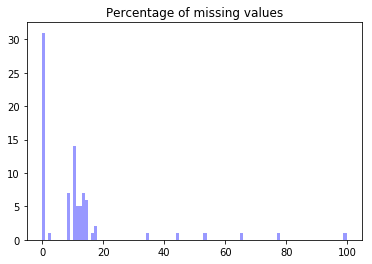

In [146]:
# Investigate patterns in the amount of missing data in each column.
sns.distplot(missing_and_not_missing, kde=False, color='blue', bins=100)
plt.title("Percentage of missing values")
plt.show()

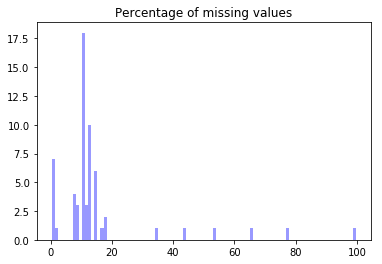

In [147]:
# Investigate patterns in the amount of missing data in each column.
sns.distplot(missing, kde=False, color='blue', bins=100)
plt.title("Percentage of missing values")
plt.show()

In [148]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

###Revoving columns whose percentage of missing values is greater then 20%
columns_to_drop = missing_and_not_missing[missing_and_not_missing >= 20]
print(columns_to_drop)

TITEL_KZ        99.757636
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
GEBURTSJAHR     44.020282
ALTER_HH        34.813699
dtype: float64


In [149]:
###Creating a list of columns to drop
columns_to_drop_list = columns_to_drop.index.tolist()
print(columns_to_drop_list)

['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']


In [150]:
###Dropping colunms
azdias2 = azdias.drop(columns_to_drop_list, axis=1)

In [151]:
###Cheking the dataset after dropping columns
azdias2.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

By analyzing the plots, we can see that the vast majority of columns have between 0 and 20% of missing values. Therefore, all columns whose percentage of missing values is greater than 20% were dropped.

Columns dropped: TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, ALTER_HH

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [152]:
# How much data is missing in each row of the dataset?
missing_values_row = azdias2.isnull().sum(axis=1).sort_values(ascending=False)
print(missing_values_row)

643174    49
732775    49
472919    48
183108    47
139316    47
691141    47
691142    47
691171    47
691183    47
139332    47
691197    47
139323    47
691212    47
691122    47
139267    47
139255    47
139250    47
139248    47
139245    47
139243    47
691317    47
691129    47
691118    47
139236    47
139478    47
690871    47
690876    47
690878    47
690887    47
139521    47
          ..
540246     0
540244     0
540243     0
540242     0
540241     0
540240     0
540239     0
540269     0
540271     0
540300     0
540289     0
540299     0
540298     0
540296     0
540295     0
540293     0
540292     0
540291     0
540290     0
540287     0
540273     0
540286     0
540284     0
540283     0
540281     0
540280     0
540277     0
540275     0
540274     0
445610     0
Length: 891221, dtype: int64


In [153]:
###Missing rows by percent
missing_percentage_row =((azdias2.isnull().sum(axis=1)/azdias2.shape[1])*100).sort_values(ascending=False)
print(missing_percentage_row)

643174    62.025316
732775    62.025316
472919    60.759494
183108    59.493671
139316    59.493671
691141    59.493671
691142    59.493671
691171    59.493671
691183    59.493671
139332    59.493671
691197    59.493671
139323    59.493671
691212    59.493671
691122    59.493671
139267    59.493671
139255    59.493671
139250    59.493671
139248    59.493671
139245    59.493671
139243    59.493671
691317    59.493671
691129    59.493671
691118    59.493671
139236    59.493671
139478    59.493671
690871    59.493671
690876    59.493671
690878    59.493671
690887    59.493671
139521    59.493671
            ...    
540246     0.000000
540244     0.000000
540243     0.000000
540242     0.000000
540241     0.000000
540240     0.000000
540239     0.000000
540269     0.000000
540271     0.000000
540300     0.000000
540289     0.000000
540299     0.000000
540298     0.000000
540296     0.000000
540295     0.000000
540293     0.000000
540292     0.000000
540291     0.000000
540290     0.000000


In [154]:
# Write code to divide the data into two subsets based on the number of missing values in each row.

# Creating a column with the number of missing values by row
azdias2['percentage_of_missing_values'] = ((azdias2.isnull().sum(axis=1)/azdias2.shape[1])*100)

In [155]:
azdias2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,percentage_of_missing_values
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.430380
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0.000000
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0.000000
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,8.860759
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0.000000


In [156]:
### Checking distinct values of missing values percentage
np.sort(azdias2['percentage_of_missing_values'].unique())

array([  0.        ,   1.26582278,   2.53164557,   3.79746835,
         5.06329114,   6.32911392,   7.59493671,   8.86075949,
        10.12658228,  11.39240506,  12.65822785,  13.92405063,
        15.18987342,  16.4556962 ,  17.72151899,  18.98734177,
        20.25316456,  21.51898734,  22.78481013,  24.05063291,
        25.3164557 ,  26.58227848,  27.84810127,  29.11392405,
        30.37974684,  31.64556962,  32.91139241,  34.17721519,
        35.44303797,  36.70886076,  37.97468354,  39.24050633,
        40.50632911,  41.7721519 ,  43.03797468,  44.30379747,
        45.56962025,  46.83544304,  48.10126582,  49.36708861,
        50.63291139,  51.89873418,  53.16455696,  54.43037975,
        55.69620253,  56.96202532,  59.49367089,  60.75949367,  62.02531646])

In [157]:
### Dividing the datasets based on the number of missing values by row
azdias2_more = azdias2[azdias2['percentage_of_missing_values'] >= 30]
azdias2_less = azdias2[azdias2['percentage_of_missing_values'] < 30]

In [158]:
### Counting rows for the first file
azdias2_more.shape

(93383, 80)

In [159]:
###Counting rows for the second file
azdias2_less.shape

(797838, 80)

In [160]:
### Compare the distribution of values for at least five columns where there are no or few missing values,
# between the two subsets.

# More than 30%
np.sort(azdias2_more['percentage_of_missing_values'].unique())

array([ 30.37974684,  31.64556962,  32.91139241,  34.17721519,
        35.44303797,  36.70886076,  37.97468354,  39.24050633,
        40.50632911,  41.7721519 ,  43.03797468,  44.30379747,
        45.56962025,  46.83544304,  48.10126582,  49.36708861,
        50.63291139,  51.89873418,  53.16455696,  54.43037975,
        55.69620253,  56.96202532,  59.49367089,  60.75949367,  62.02531646])

In [161]:
### Compare the distribution of values for at least five columns where there are no or few missing values,
# between the two subsets.

# Less than 30%
np.sort(azdias2_less['percentage_of_missing_values'].unique())

array([  0.        ,   1.26582278,   2.53164557,   3.79746835,
         5.06329114,   6.32911392,   7.59493671,   8.86075949,
        10.12658228,  11.39240506,  12.65822785,  13.92405063,
        15.18987342,  16.4556962 ,  17.72151899,  18.98734177,
        20.25316456,  21.51898734,  22.78481013,  24.05063291,
        25.3164557 ,  26.58227848,  27.84810127,  29.11392405])

In [162]:
#No missing values
azdias2_no_missing = azdias2_less[azdias2_less['percentage_of_missing_values'] ==0]

#A few missing values
azdias2_few_missing = azdias2_less[(azdias2_less['percentage_of_missing_values'] >0) &
                                   (azdias2_less['percentage_of_missing_values'] <=10)]

In [163]:
azdias2_no_missing.shape

(623209, 80)

In [164]:
azdias2_few_missing.shape

(123917, 80)

In [165]:
azdias2_no_missing.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,percentage_of_missing_values
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0.0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0.0
6,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,4.0,...,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0.0


In [166]:
azdias2_few_missing.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,percentage_of_missing_values
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,8.860759
12,3.0,1.0,6.0,5.0,3.0,4.0,2.0,4.0,1.0,3.0,...,3.0,1.0,0.0,1.0,5.0,5.0,3.0,6.0,4.0,7.594937
16,1.0,2.0,1.0,4.0,3.0,1.0,4.0,5.0,1.0,3.0,...,3.0,1.0,0.0,1.0,3.0,4.0,1.0,2.0,1.0,7.594937
18,2.0,2.0,6.0,2.0,4.0,1.0,5.0,4.0,1.0,1.0,...,3.0,2.0,1.0,1.0,3.0,3.0,3.0,4.0,3.0,3.797468
25,1.0,1.0,3.0,3.0,5.0,3.0,5.0,4.0,3.0,4.0,...,2.0,0.0,0.0,1.0,4.0,5.0,3.0,2.0,5.0,6.329114


In [167]:
### Selecting 10 random columns
random_columns = np.random.choice(azdias2_no_missing.columns, 10).tolist()

In [168]:
print('The list of random columns to be compared is: {}'.format(random_columns))
print('\n')
print('The length of the list is: {}'.format(len(random_columns)))

The list of random columns to be compared is: ['SEMIO_SOZ', 'PLZ8_GBZ', 'RELAT_AB', 'LP_FAMILIE_FEIN', 'RELAT_AB', 'NATIONALITAET_KZ', 'SEMIO_MAT', 'INNENSTADT', 'PLZ8_HHZ', 'GFK_URLAUBERTYP']


The length of the list is: 10


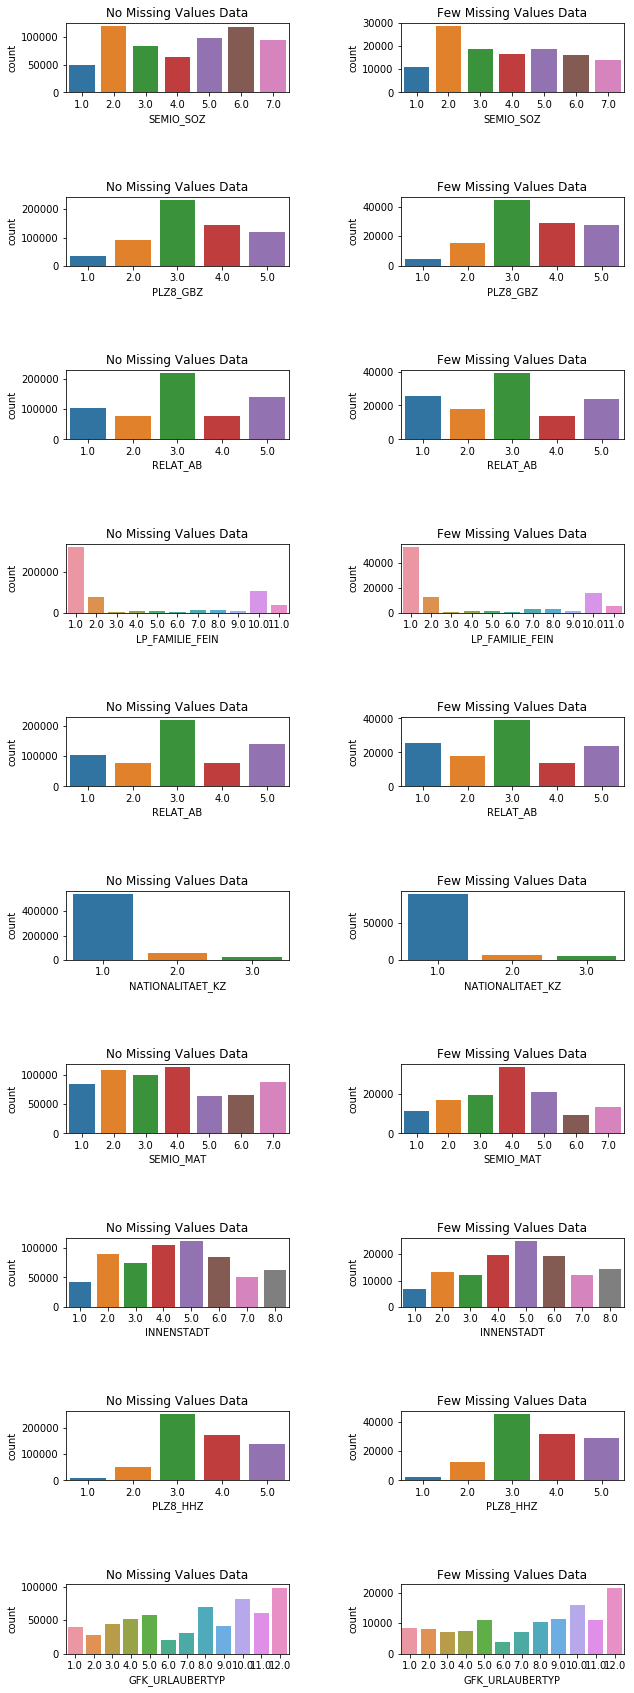

In [169]:
f, axes = plt.subplots(nrows=len(random_columns), ncols=2, figsize = (10,30))
plt.subplots_adjust(hspace = 1.5, wspace=0.5)

for i in range(0, len(random_columns)):
    sns.countplot(x=random_columns[i], data=azdias2_no_missing,  ax=axes[i, 0])
    axes[i][0].set_title('No Missing Values Data')
    sns.countplot(x=random_columns[i], data=azdias2_few_missing, ax=axes[i, 1])
    axes[i][1].set_title('Few Missing Values Data')

plt.show()                          

#### Discussion 1.1.3: Assess Missing Data in Each Row

We can see that, whether the data has few or no missing rows, the distributions are very similar. The big difference is the column count (y-axis), whose values to the left way higher than those to the right. The magnitude of the data is different, but the way values are distributed across both charts is similar.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [170]:
# How many features are there of each data type?
feat_info2['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [171]:
feat_info2.head()

,attribute,information_level,type,missing_or_unknown,m_or_u1,m_or_u2,m_or_u3
0,AGER_TYP,person,categorical,"-1,0",-1,0,None
1,ALTERSKATEGORIE_GROB,person,ordinal,"-1,0,9",-1,0,9
2,ANREDE_KZ,person,categorical,"-1,0",-1,0,None
3,CJT_GESAMTTYP,person,categorical,0,0,None,None
4,FINANZ_MINIMALIST,person,ordinal,-1,-1,None,None


In [172]:
### Removing the columns with many missing values
attribute_list = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
feat_info2_clean = feat_info2[~feat_info2['attribute'].isin(attribute_list)]
feat_info2_clean.shape

(79, 7)

In [173]:
# How many features are there of each data type?
feat_info2_clean['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [174]:
# Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?

#Getting the list of categorical features
categorial_features = feat_info2_clean['attribute'][feat_info2_clean['type'] == 'categorical'].tolist()
print(categorial_features)
print(len(categorial_features))

['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
18


In [175]:
#Assessing categorical variables
multi_level = []
binary = []
for feature in categorial_features: 
    print(feature)
    print(azdias2[feature].unique())
    print(len(azdias2[feature].unique()))
    if(len(azdias2[feature].unique()) > 3):
        multi_level.append(feature)
    else:
        binary.append(feature)
    print('\n')
    
print('The list with multi_level categoricals contains {} columns and they are: {}\n'.format(len(multi_level), multi_level))
print('The list with binary categoricals contains {} columns and they are {}: '.format(len(binary), binary))

ANREDE_KZ
[ 1.  2.]
2


CJT_GESAMTTYP
[  2.   5.   3.   4.   1.   6.  nan]
7


FINANZTYP
[ 4.  1.  6.  5.  2.  3.]
6


GFK_URLAUBERTYP
[ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
13


GREEN_AVANTGARDE
[ 0.  1.]
2


LP_FAMILIE_FEIN
[  2.   5.   1.  nan  10.   7.  11.   3.   8.   4.   6.   9.]
12


LP_FAMILIE_GROB
[  2.   3.   1.  nan   5.   4.]
6


LP_STATUS_FEIN
[  1.   2.   3.   9.   4.  10.   5.   8.   6.   7.  nan]
11


LP_STATUS_GROB
[  1.   2.   4.   5.   3.  nan]
6


NATIONALITAET_KZ
[ nan   1.   3.   2.]
4


SHOPPER_TYP
[ nan   3.   2.   1.   0.]
5


SOHO_KZ
[ nan   1.   0.]
3


VERS_TYP
[ nan   2.   1.]
3


ZABEOTYP
[ 3.  5.  4.  1.  6.  2.]
6


GEBAEUDETYP
[ nan   8.   1.   3.   2.   6.   4.   5.]
8


OST_WEST_KZ
[nan 'W' 'O']
3


CAMEO_DEUG_2015
[ nan   8.   4.   2.   6.   1.   9.   5.   7.   3.]
10


CAMEO_DEU_2015
[nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C

In [176]:
### Accessing binary variable that takes on non-numeric values
azdias2['OST_WEST_KZ'].unique()

array([nan, 'W', 'O'], dtype=object)

In [177]:
### Checking how values are distributed
azdias2['OST_WEST_KZ'].value_counts()

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64

In [178]:
### Re-encode categorical variable(s) to be kept in the analysis.

# Reencoding OST_WEST_KZ 
codes1 = {'O': 0, 'W': 1}
azdias2 = azdias2.replace({'OST_WEST_KZ': codes1})

# Checking unique values
azdias2['OST_WEST_KZ'].unique()

array([ nan,   1.,   0.])

In [179]:
### Dropping multi-level categorical features
azdias3 =  azdias2.drop(multi_level, axis=1)
feat_info2_clean = feat_info2_clean[~feat_info2_clean['attribute'].isin(multi_level)]

print('Shape of the data before dropping multi-level categorical features: {}'.format(azdias2.shape))
print('Shape of the data after dropping multi-level categorical features: {}'.format(azdias3.shape))
print('Shape of the attributes tables after dropping multi-level categorical features: {}'.format(feat_info2_clean.shape))

Shape of the data before dropping multi-level categorical features: (891221, 80)
Shape of the data after dropping multi-level categorical features: (891221, 67)
Shape of the attributes tables after dropping multi-level categorical features: (66, 7)


In [180]:
### Double-cheking binary categoricals
for feature in binary: 
    print(feature)
    print(azdias3[feature].unique())
    print('The length is: {}'.format(len(azdias3[feature].unique())))
    print('\n')

ANREDE_KZ
[ 1.  2.]
The length is: 2


GREEN_AVANTGARDE
[ 0.  1.]
The length is: 2


SOHO_KZ
[ nan   1.   0.]
The length is: 3


VERS_TYP
[ nan   2.   1.]
The length is: 3


OST_WEST_KZ
[ nan   1.   0.]
The length is: 3




#### Discussion 1.2.1: Re-Encode Categorical Features

Two-level categoricals that take numeric values have been kept without any changes

The binary variable that takes on non-numeric values (OST_WEST_KZ) has been reencoded

Multi-level categoricals have been dropped for the sake of simplicity. If further analysis is required, we can do one-hot enconding for these 13 attributes.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### Checking Dictionary

####  1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [181]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
sorted(azdias3['PRAEGENDE_JUGENDJAHRE'].unique())

[nan,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0]

In [182]:
###Creating a decade dictionary: 0:1940s, 1:1950s, 2:1960s, 3:1970s, 4:1980s, 5:1990s
decade = {1:0, 2:0,                     #1940s
          3:1, 4:1,                     #1950s
          5:2, 6:2, 7:2,                #1960s
          8:3, 9:3,                     #1970s
          10:4, 11:4, 12:4, 12:4, 13:4, #1980s
          14:5, 15:5}                   #1990s

###Creating a movement dictionary: 0 = Mainstream, 1 = Avantgarde
movement = {1:0, 3:0, 5:0, 8:0, 10:0, 12:0, 14:0,      
            2:1, 4:1, 6:1, 7:1, 9:1, 11:1, 13:1, 15:1}

###Creating new columns based on the new encoding
azdias3['Decade']   = azdias3['PRAEGENDE_JUGENDJAHRE'].replace(decade)
azdias3['Movement'] = azdias3['PRAEGENDE_JUGENDJAHRE'].replace(movement)

###Cheking newly created columns
azdias3[['PRAEGENDE_JUGENDJAHRE', 'Decade', 'Movement']].head()

,PRAEGENDE_JUGENDJAHRE,Decade,Movement
0,NaN,NaN,NaN
1,14.0,5.0,0.0
2,15.0,5.0,1.0
3,8.0,3.0,0.0
4,8.0,3.0,0.0


### Checking Dictionary 

#### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [183]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
sorted(azdias3['CAMEO_INTL_2015'].unique())

[nan,
 12.0,
 13.0,
 14.0,
 15.0,
 22.0,
 23.0,
 24.0,
 25.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 41.0,
 43.0,
 44.0,
 45.0,
 51.0,
 52.0,
 54.0,
 55.0]

In [184]:
###Creating a household dictionary
#0: Wealthy
#1: Prosperous
#2: Comfortable
#3: Less Affluent
#4: Poorer

household = {11:0, 12:0, 13:0, 14:0, 15:0,
             21:1, 22:1, 23:1, 24:1, 25:1,
             31:2, 32:2, 33:2, 34:2, 35:2,
             41:3, 42:3, 43:3, 44:3, 45:3,
             51:4, 52:4, 53:4, 54:4, 55:4}


###Creating a Life Stage dictionary
#0: Pre-Family Couples & Singles
#1: Young Couples With Children
#2: Families With School Age Children
#3: Older Families & Mature Couples
#4: Elders In Retirement

life_stage = {11:0, 21:0, 31:0, 41:0, 51:0,
              12:1, 22:1, 32:1, 42:1, 52:1,
              13:2, 23:2, 33:2, 43:2, 53:2,
              14:3, 24:3, 34:3, 44:3, 54:3,
              15:4, 25:4, 35:4, 45:4, 55:4}

###Creating new columns based on the new encoding
azdias3['Household']  = azdias3['CAMEO_INTL_2015'].replace(household)
azdias3['Life_Stage'] = azdias3['CAMEO_INTL_2015'].replace(life_stage)

###Cheking newly created columns
azdias3[['CAMEO_INTL_2015', 'Household', 'Life_Stage']].head()

,CAMEO_INTL_2015,Household,Life_Stage
0,NaN,NaN,NaN
1,51.0,4.0,0.0
2,24.0,1.0,3.0
3,12.0,0.0,1.0
4,43.0,3.0,2.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

**PRAEGENDE_JUGENDJAHRE:** We broke it into two variables (Decade and Movement). The fact that we don't have all combinations of East vs West (E, W, E+W) for each decade made us decide not to break the variable into a third column.


**Decade**<br/>
0:1940s<br/>
1:1950s<br/>
2:1960s<br/>
3:1970s<br/>
4:1980s<br/>
5:1990s<br/>


**Movement**<br/>
0: Mainstream<br/>
1: Avantgarde<br/>
<br/>

**CAMEO_INTL_2015:** We broke it into two column as well (Household and Life Stage). Because we have all 25 combinations of life stage and household, we were able to code all possible cases.

**Household**<br/>
0: Wealthy<br/>
1: Prosperous<br/>
2: Comfortable<br/>
3: Less Affluent<br/>
4: Poorer<br/>

**Life Stage**<br/>
0: Pre-Family Couples & Singles<br/>
1: Young Couples With Children<br/>
2: Families With School Age Children<br/>
3: Older Families & Mature Couples<br/>
4: Elders In Retirement           

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [185]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

#Getting the list of mixed features
feat_info2_clean['type'].value_counts()

ordinal        49
numeric         6
mixed           6
categorical     5
Name: type, dtype: int64

In [186]:
mixed_features = feat_info2_clean['attribute'][feat_info2_clean['type'] == 'mixed'].tolist()
print(mixed_features)

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


### Checking dictionary 

#### 8.6. PLZ8_BAUMAX
Most common building type within the PLZ8 region
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes
-  2: mainly 3-5 family homes
-  3: mainly 6-10 family homes
-  4: mainly 10+ family homes
-  5: mainly business buildings

In [189]:
# Investigate "PLZ8_BAUMAX" and engineer two new variables.
sorted(azdias3['PLZ8_BAUMAX'].unique())

[nan, 1.0, 2.0, 3.0, 4.0, 5.0]

In [190]:
###Creating a construction_type dictionary 
#0: Business building
#1: Family home

construction_type = {5:0,
                     1:1, 2:1, 3:1, 4:1}

###Creating a number of people living
#0: 0 people
#1: mainly 1-2 family homes
#2: mainly 3-5 family homes
#3: mainly 6-10 family homes
#4: mainly 10+ family homes

number_of_people = {5:0,
                    1:1,
                    2:2,
                    3:3,
                    4:4}


### Creating new columns based on the new encoding
azdias3['Construction_Type'] = azdias3['PLZ8_BAUMAX'].replace(construction_type)
azdias3['Number_of_People'] = azdias3['PLZ8_BAUMAX'].replace(number_of_people)

### Checking newly created columns
azdias3[['PLZ8_BAUMAX', 'Construction_Type', 'Number_of_People']].head()

,PLZ8_BAUMAX,Construction_Type,Number_of_People
0,NaN,NaN,NaN
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,2.0,1.0,2.0


In [113]:
# Do whatever you need to in order to ensure that the dataframe only contains the columns that should be passed
# to the algorithm functions

missing_percentage_final =((azdias3.isnull().sum()/len(azdias3))*100).sort_values(ascending=False)
print(missing_percentage_final)
print('\n')
print('Shape of the dataset to be passed to function: {} rows and {} columns'.format(azdias2.shape[0], azdias2.shape[1]))

KKK                             17.735668
REGIOTYP                        17.735668
W_KEIT_KIND_HH                  16.605084
KBA05_ANTG1                     14.959701
KBA05_ANTG2                     14.959701
KBA05_ANTG3                     14.959701
KBA05_ANTG4                     14.959701
KBA05_GBZ                       14.959701
MOBI_REGIO                      14.959701
Number_of_People                13.073637
PLZ8_ANTG3                      13.073637
Construction_Type               13.073637
PLZ8_ANTG2                      13.073637
PLZ8_ANTG1                      13.073637
PLZ8_ANTG4                      13.073637
PLZ8_BAUMAX                     13.073637
PLZ8_HHZ                        13.073637
PLZ8_GBZ                        13.073637
HEALTH_TYP                      12.476816
VERS_TYP                        12.476816
PRAEGENDE_JUGENDJAHRE           12.136608
Decade                          12.136608
Movement                        12.136608
KBA13_ANZAHL_PKW                11

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [3]:
def clean_data(df, df_info):
    
    ### Identifing missing or unknown data values and converting them to NaNs.
    print('### Identifing missing or unknown data values and converting them to NaNs')
    missing_values = df.isnull().sum()
    print('Total number of missing values {}\n'.format(missing_values.sum()))   
                    
    print('### Number of missing values by column')
    print(missing_values[df.isnull().sum() != 0].sort_index())
    print('\n')

    ### Creating columns for missing values
    print('### Cleansing the missing_or_unknown column')
    df_info2 = df_info.copy()
    df_info2['missing_or_unknown'] = df_info2['missing_or_unknown'].str.replace('[', '').str.replace(']', '')

    ### Creating separate columns for each missing or unknown value
    print('### Creating separate columns for each missing or unknown value')
    df_info2[['m_or_u1', 'm_or_u2', 'm_or_u3']] = df_info2.missing_or_unknown.str.split(',', expand=True)
    df_info3 = df_info2[['attribute', 'm_or_u1', 'm_or_u2', 'm_or_u3']]

    ### Capturing attributes in the attributes table that contain X or XX and saving them to list
    print('### Capturing attributes in the attributes table that contain X or XX and saving them to a list')
    cols = ['m_or_u1', 'm_or_u2', 'm_or_u3']
    replace = []

    for i in cols:
          replace.append((df_info3['attribute'][df_info3[i].isin(['X', 'XX'])]).tolist())
    
    attributes = []
    for i in range(0, len(replace)):
          for j in range(0, len(replace[i])):
                attributes.append(replace[i][j])
        
    print('The attributes are: {}\n'.format(attributes))

    ### Replacing X and XX in the dataset
    print('### Replacing X and XX in the dataset')
    for col in attributes:
          df[col] = df[col].astype(str).str.replace('X', '0').str.replace('XX', '00') 
    
    df_info4 = df_info3.copy()
    df_info4 = df_info4.set_index('attribute').transpose()


    ### Converting values to float
    print('### Converting values to float in the attributes table')
    
    # Attributes table
    for col in df_info4.columns:
        try:
            df_info4[col] = df_info4[col].astype(float)
        except:
            continue
    
    print('### Converting values to float in the dataset')
    # Dataset   
    for col in df.columns:
        try:
            df[col] = df[col].astype(float)
        except:
            continue


    ### Converting the DataFrame into a Dictionary
    print('### Creating a dictionary from the attributes tables')
    df_info4_dict = df_info4.to_dict(orient='list')


    ### Replacing missing or unknown values
    print('### Replacing missing or unknown values')
    df = df.replace(df_info4_dict, np.nan)
    print('Values replaced!\n')

    ### Cheking data types for all columns 
    df.dtypes.value_counts()
    
    ### Number of missing values after replacement
    print('### Checking the number of missing values after replacement')
    df_missing = df.isnull().sum()
    print('The number is: {}'.format(df_missing.sum()))

    ### Number of newly detected missing values
    print('Number of newly detected missing values:{}/n'.format(df_missing.sum() - missing_values.sum()))
    
    ######################################################################################

    ### Assess Missing data in each column

    ### Number of missing values by column
    print('### Number of missing data by column')
    df.isnull().sum().sort_values(ascending=False)
    
    ### Percentage of missing values by column
    print('\n### Percentage of missing values by column---')
    missing_and_not_missing =((df.isnull().sum()/len(df))*100).sort_values(ascending=False)
    print(missing_and_not_missing)
    
    ### Investigate patterns in the amount of missing data in each column.
    sns.distplot(missing_and_not_missing, kde=False, color='blue', bins=100)
    plt.title("Percentage of missing values")
    plt.show()
    
    ### Revoving columns whose percentage of missing values is greater then 30%
    print('\n### Revoving columns whose percentage of missing values is greater then 30%')
    columns_to_drop = missing_and_not_missing[missing_and_not_missing >= 30]

    ###Creating a list of columns to drop
    columns_to_drop_list = columns_to_drop.index.tolist()
    print('This is the list of columns to be dropped: {}'.format(columns_to_drop_list))

    ###Dropping colunms
    df2 = df.drop(columns_to_drop_list, axis=1)
    print('Columns dropped!\n')

    ######################################################################################

    ### Assessing Missing Data in Each Row

    ### How much data is missing in each row of the dataset?
    print('### Assessing Missing Data in Each Row')
    missing_values_row = df2.isnull().sum(axis=1).sort_values(ascending=False)
    print('Missing rows by number')
    print(missing_values_row)
    print('\n')

    ### Missing rows by percent
    missing_percentage_row =((df2.isnull().sum(axis=1)/df2.shape[1])*100).sort_values(ascending=False)
    print('Missing_rows by percertage')
    print(missing_percentage_row)
    print('\n')

    ### Checking the number of rows by percentage of missing values
    print('### Counting missing_rows by percertage')
    missing_percentage_row.value_counts().sort_index(ascending=False)

          
    ### Write code to divide the data into two subsets based on the number of missing values in each row ###

    ### Creating a column with the number of missing values
    print('### Creating a column with the number of missing values\n')
    df2['number_of_missing_values'] = df2.isnull().sum(axis=1)

    ### Dividing the datasets based on the number of missing values by row
    print('### Dividing the datasets based on the number of missing values by row')
    df2_more = df2[df2['number_of_missing_values'] >= 10]
    df2_less = df2[df2['number_of_missing_values'] < 10]

    ### 153 Counting rows for the first file
    print('Counting rows for the first file')
    print('The first file has {} rows and {} columns\n'.format(df2_more.shape[0], df2_more.shape[1]))
          
    ### Counting rows for the second file
    print('Counting rows for the second file')
    print('The first file has {} rows and {} columns\n'.format(df2_less.shape[0], df2_less.shape[1]))

    ### Compare the distribution of values for at least five columns where there are no or few missing values,
    ### between the two subsets.
    df2_less['number_of_missing_values'].unique()


    ### No missing values
    print('### Creating dataset with no missing values')
    df2_no_missing = df2_less[df2_less['number_of_missing_values'] ==0]

    ### A few missing values
    print('### Creating dataset with a few missing values')
    df2_few_missing = df2_less[(df2_less['number_of_missing_values'] >=1) & (df2_less['number_of_missing_values'] <=5)]

    ### Selecting 10 random columns

    ## No missing values
    print('\n### Selecting 10 random columns')
    random_columns = np.random.choice(df2_no_missing.columns, 10).tolist()
    print('The list of random columns to be compared is: {}\n'.format(random_columns))
    print('The length of the list is: {}\n'.format(len(random_columns)))
    print('### Plotting random columns')
    
    ### Plotting the random columns
    f, axes = plt.subplots(nrows=len(random_columns), ncols=2, figsize = (10,30))
    plt.subplots_adjust(hspace = 1.5, wspace=0.5)

    for i in range(0, len(random_columns)):
        sns.countplot(x=random_columns[i], data=df2_no_missing,  ax=axes[i, 0])
        axes[i][0].set_title('No Missing')
        sns.countplot(x=random_columns[i], data=df2_few_missing, ax=axes[i, 1])
        axes[i][1].set_title('Few Missing')
    plt.show()

    ###########################################################################################

    ### Select and Re-Encode Features

    ### Removing the columns with many missing values
    print('\n ### Removing the columns with many missing values from the attributes table')
    attribute_list = columns_to_drop_list
    df_info3 = df_info2[~df_info2['attribute'].isin(attribute_list)]

    ### How many features are there of each data type?
    print('### Checking the number of features for each type')
    df_info3['type'].value_counts()

    ### Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?

    ### Getting the list of categorical features
    print('### Getting the list of categorical features')
    categorial_features = df_info3['attribute'][df_info3['type'] == 'categorical'].tolist()
    print(categorial_features)

    ### Assesing categorical variables
    print('### Assesing categorical variables\n')
    multi_level = []
    binary = []
          
    for feature in categorial_features:
        print(feature)
        print(df2[feature].unique())
        print(len(df2[feature].unique()))
        if(len(df2[feature].unique()) > 3):
            multi_level.append(feature)
        else:
            binary.append(feature)
    
    
    print('The list with multi_level categoricals contains: {}'.format(multi_level))
    print('The list with binary categoricals contains: {}\n'.format(binary))


    ### Accessing binary variable that takes on non-numeric values
    df2['OST_WEST_KZ'].unique()

    ### Checking how values are distributed
    df2['OST_WEST_KZ'].value_counts()

    ### Re-encode categorical variable(s) to be kept in the analysis.

    ### Reencoding OST_WEST_KZ 
    print('### Reencoding OST_WEST_KZ')
    codes1 = {'O': 0, 'W': 1}
    df2 = df2.replace({'OST_WEST_KZ': codes1})

    ### Checking unique values
    df2['OST_WEST_KZ'].unique()


    ### Dropping multi-level categorical features
    print('\n ###Dropping multi-level categorical features\n')
    df3 = df2.drop(multi_level, axis=1)
    df_info4 = df_info3[~df_info3['attribute'].isin(multi_level)]
    
    print('Shape of the data before dropping multi-level categorical features: {}'.format(df2.shape))
    print('Shape of the data after dropping multi-level categorical features: {}'.format(df3.shape))
    print('Shape of the attributes tables after dropping multi-level categorical features: {}\n'.format(df_info4.shape))
    

    ### Double-cheking binary categoricals
    print('### Double-checking binary categoricals')      
    for feature in binary:
        print('Feature name: {}'.format(feature))
        print('Unique values: {}'.format(df3[feature].unique()))
        print('Number of unique values: {}'.format(len(df3[feature].unique())))
        print('\n')
    
    print("Categoricals checked! Now, let's do Feature Engineering\n")

    ####################################################################################################

    ### Feature Engineering - Enginer Mixed-type features

    ### Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    print('### Mixed-type features - PRAEGENDE_JUGENDJAHRE')
    sorted(df3['PRAEGENDE_JUGENDJAHRE'].unique())

    ### Creating a decade dictionary: 0:1940s, 1:1950s, 2:1960s, 3:1970s, 4:1980s, 5:1990s
    decade = {1:0, 2:0,
              3:1, 4:1,
              5:2, 6:2, 7:2,
              8:3, 9:3,
              10:4, 11:4, 12:4, 12:4, 13:4,
              14:5, 15:5}

    ### Creating a movement dictionary: 0 = Mainstream, 1 = Avantgarde
    movement = {1:0, 3:0, 5:0, 8:0, 10:0, 12:0, 14:0,
                2:1, 4:1, 6:1, 7:1, 9:1, 11:1, 13:1, 15:1}

    ### Creating new columns based on the new encoding
    df3['Decade']   = df3['PRAEGENDE_JUGENDJAHRE'].replace(decade)
    df3['Movement'] = df3['PRAEGENDE_JUGENDJAHRE'].replace(movement)

    ### Checking newly created columns
    print('PRAEGENDE_JUGENDJAHRE broken into two other columns!')
    df3[['PRAEGENDE_JUGENDJAHRE', 'Decade', 'Movement']].head()
    print('\n')
    

    ### Investigate "CAMEO_INTL_2015" and engineer two new variables
    print('### Mixed-type features - CAMEO_INTL_2015')
    sorted(df3['CAMEO_INTL_2015'].unique())

    ### Creating a household dictionary
    #0: Wealthy
    #1: Prosperous
    #2: Comfortable
    #3: Less Affluent
    #4: Poorer

    household = {11:0, 12:0, 13:0, 14:0, 15:0,
                 21:1, 22:1, 23:1, 24:1, 25:1,
                 31:2, 32:2, 33:2, 34:2, 35:2,
                 41:3, 42:3, 43:3, 44:3, 45:3,
                 51:4, 52:4, 53:4, 54:4, 55:4}

          
    ### Creating a Life Stage dictionary
    #0: Pre-Family Couples & Singles
    #1: Young Couples With Children
    #2: Families With School Age Children
    #3: Older Families & Mature Couples
    #4: Elders In Retirement

    life_stage = {11:0, 21:0, 31:0, 41:0, 51:0,
                  12:1, 22:1, 32:1, 42:1, 52:1,
                  13:2, 23:2, 33:2, 43:2, 53:2,
                  14:3, 24:3, 34:3, 44:3, 54:3,
                  15:4, 25:4, 35:4, 45:4, 55:4}

    ### Creating new columns based on the new encoding
    df3['Household']  = df3['CAMEO_INTL_2015'].replace(household)
    df3['Life_Stage'] = df3['CAMEO_INTL_2015'].replace(life_stage)

    ### Checking newly created columns
    print('CAMEO_INTL_2015 broken into two other columns!')
    df3[['CAMEO_INTL_2015', 'Household', 'Life_Stage']].head()
    print('\n')


    ### Investigate "PLZ8_BAUMAX" and engineer two new variables
    print('### Mixed-type features - PLZ8_BAUMAX')
    sorted(df3['PLZ8_BAUMAX'].unique())

    ### Creating a construction_type dictionary 
    #0: Business building
    #1: Family home

    construction_type = {5:0, 1:1, 2:1, 3:1, 4:1}

    ### Creating a number of people living
    #0: 0 people
    #1: mainly 1-2 family homes
    #2: mainly 3-5 family homes
    #3: mainly 6-10 family homes
    #4: mainly 10+ family homes

    number_of_people = {5:0, 1:1, 2:2, 3:3, 4:4}

    ### Creating new columns based on the new encoding
    df3['Construction_Type'] = df3['PLZ8_BAUMAX'].replace(construction_type)
    df3['Number_of_People'] = df3['PLZ8_BAUMAX'].replace(number_of_people)

    ### Checking newly created columns
    print('PLZ8_BAUMAX broken into two other columns!')
    df3[['PLZ8_BAUMAX', 'Construction_Type', 'Number_of_People']].head()
    print('\n')
    
    print('Missing columns by percentage - Final check')
    missing_percentage_final =((df3.isnull().sum()/len(df3))*100).sort_values(ascending=False)
    print(missing_percentage_final)
    print('\n')
    print('Shape of the dataset to be passed to function: {} rows and {} columns'.format(df3.shape[0], df3.shape[1]))
    print('Dataset cleansed and ready to be imputed!\n')
    
    ### Imputing missing values
    print('Imputting missing values')
    imputer = Imputer(strategy='most_frequent')
    df4 = pd.DataFrame(imputer.fit_transform(df3), columns = df3.columns, index = df3.index)
    print('Values replaced!\n')
    
    ### Appling feature scaling to the general population demographics data
    print('Appling feature scaling to the general population demographics data')
    scaler = StandardScaler()
    df5 = pd.DataFrame(scaler.fit_transform(df4), columns=df4.columns, index=df4.index)
    print('Data scaled! Now, we are ready to do PCA! End of function')    
 
    return df5

### Identifing missing or unknown data values and converting them to NaNs
Total number of missing values 4896838

### Number of missing values by column
ALTER_HH                73499
ANZ_HAUSHALTE_AKTIV     93148
ANZ_HH_TITEL            97008
ANZ_PERSONEN            73499
ANZ_TITEL               73499
ARBEIT                  97216
BALLRAUM                93740
CAMEO_DEUG_2015         98979
CAMEO_DEU_2015          98979
CAMEO_INTL_2015         98979
CJT_GESAMTTYP            4854
EWDICHTE                93740
GEBAEUDETYP             93148
GEBAEUDETYP_RASTER      93155
GFK_URLAUBERTYP          4854
HH_EINKOMMEN_SCORE      18348
INNENSTADT              93740
KBA05_ANTG1            133324
KBA05_ANTG2            133324
KBA05_ANTG3            133324
KBA05_ANTG4            133324
KBA05_BAUMAX           133324
KBA05_GBZ              133324
KBA13_ANZAHL_PKW       105800
KKK                    121196
KK_KUNDENTYP           584612
KONSUMNAEHE             73969
LP_FAMILIE_FEIN          4854
LP_FAMI

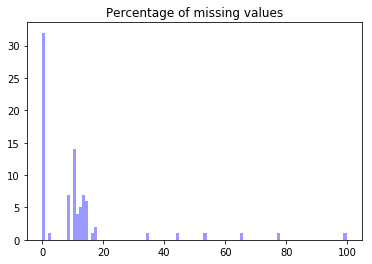


### Revoving columns whose percentage of missing values is greater then 30%
This is the list of columns to be dropped: ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
Columns dropped!

### Assessing Missing Data in Each Row
Missing rows by number
643174    48
732775    48
472919    47
225998    46
75806     46
225966    46
442228    46
75801     46
75800     46
225968    46
312579    46
75796     46
442245    46
75791     46
312574    46
27688     46
442248    46
442252    46
75786     46
75784     46
27708     46
226021    46
75781     46
75777     46
565958    46
225960    46
225958    46
565942    46
782614    46
225907    46
          ..
540306     0
540305     0
540304     0
540303     0
540301     0
540300     0
540299     0
540325     0
540327     0
540355     0
540344     0
540354     0
540353     0
540351     0
540350     0
540349     0
540347     0
540346     0
540345     0
540343     0
540328     0
540340     0
540339     0
540338     0
5

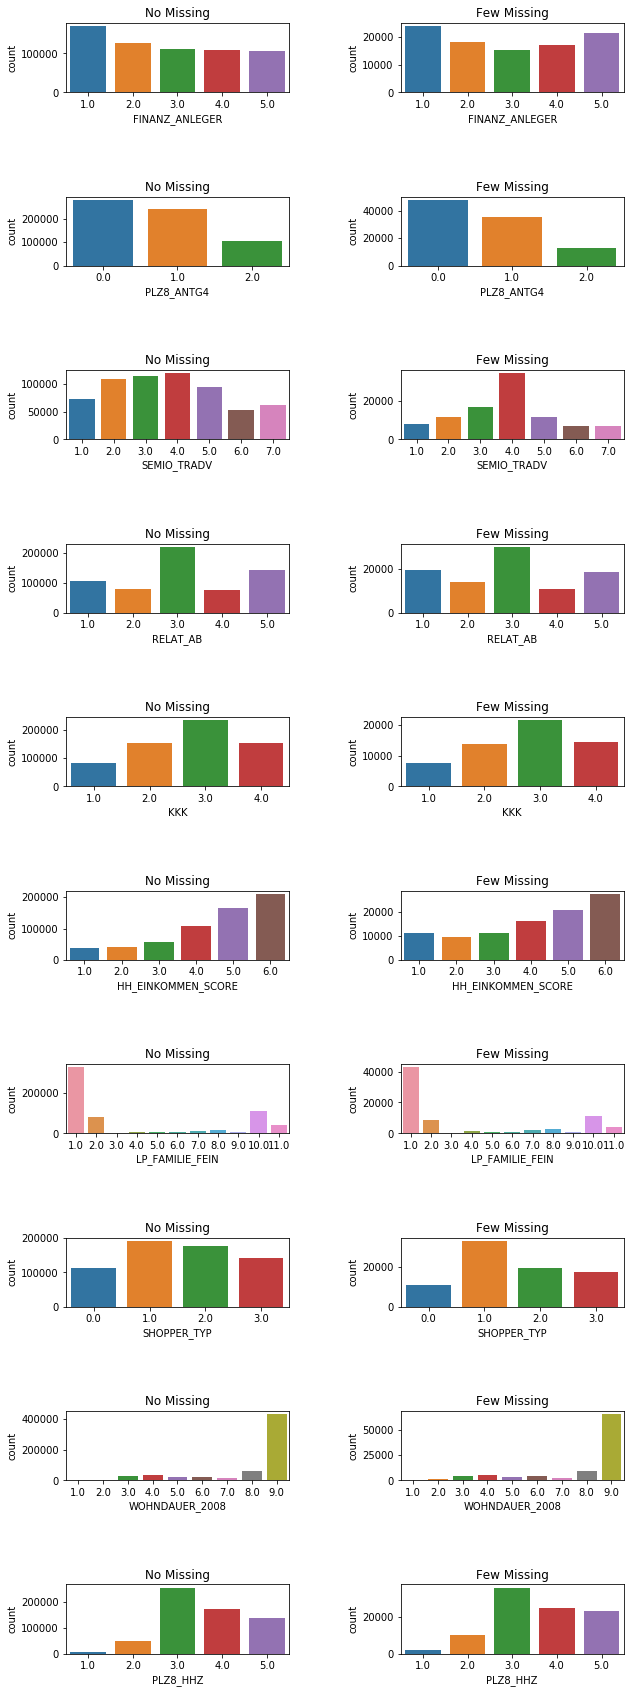


 ### Removing the columns with many missing values from the attributes table
### Checking the number of features for each type
### Getting the list of categorical features
['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
### Assesing categorical variables

ANREDE_KZ
[ 1.  2.]
2
CJT_GESAMTTYP
[  2.   5.   3.   4.   1.   6.  nan]
7
FINANZTYP
[ 4.  1.  6.  5.  2.  3.]
6
GFK_URLAUBERTYP
[ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
13
GREEN_AVANTGARDE
[ 0.  1.]
2
LP_FAMILIE_FEIN
[  2.   5.   1.  nan  10.   7.  11.   3.   8.   4.   6.   9.]
12
LP_FAMILIE_GROB
[  2.   3.   1.  nan   5.   4.]
6
LP_STATUS_FEIN
[  1.   2.   3.   9.   4.  10.   5.   8.   6.   7.  nan]
11
LP_STATUS_GROB
[  1.   2.   4.   5.   3.  nan]
6
NATIONALITAET_

In [4]:
### Calling the function

# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

azdias_cleansed = clean_data(azdias, feat_info)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

### Observations
#### Feature Scaling is part of the cleaning function

In [5]:
### Checking the dataset before applying PCA
azdias_cleansed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ARBEIT,ORTSGR_KLS9,RELAT_AB,number_of_missing_values,Decade,Movement,Household,Life_Stage,Construction_Type,Number_of_People
0,-0.751680,-1.045218,-0.056416,0.804890,-0.303378,1.285741,1.429871,-0.055511,-0.494701,0.938197,...,0.758890,-0.120115,-0.049267,2.818492,0.994991,-0.494701,1.040706,-1.095866,0.350147,-0.287220
1,-1.743339,0.956738,-1.570358,1.487601,-1.059731,1.285741,0.757254,1.422415,-0.494701,0.938197,...,-0.263506,-0.120115,0.729399,-0.428047,0.994991,-0.494701,1.040706,-1.095866,0.350147,-0.287220
2,0.239980,0.956738,-1.570358,0.804890,-1.816084,-0.675554,0.084637,1.422415,2.021423,0.938197,...,-0.263506,-0.120115,-0.827934,-0.428047,0.994991,2.021423,-0.978987,0.879581,0.350147,-0.287220
3,1.231640,0.956738,0.700556,-0.560532,1.209329,-0.675554,-1.260597,-0.794475,-0.494701,-0.385397,...,-1.285903,-1.039247,-0.049267,0.113043,-0.363493,-0.494701,-1.652219,-0.437384,0.350147,-0.287220
4,0.239980,-1.045218,0.700556,0.122179,0.452976,-1.329319,0.084637,-0.794475,-0.494701,0.938197,...,0.758890,0.339451,1.508065,-0.428047,-0.363493,-0.494701,0.367475,0.221098,0.350147,0.759333


### Discussion 2.1: Apply Feature Scaling

Again, for the sake of simplicity, we decided to perform a simple imputation, replacing missing values with the most frequent  

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [6]:
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            data_pca - the transformed X matrix with new number of components
    '''
    pca = PCA(n_components)
    data_pca = pca.fit_transform(data)
    return pca, data_pca

In [7]:
def variance_plot(pca):
    '''
    Creates a plot with the amount of variance explained by each component
    
    INPUT: pca - the result of instantiation of PCA in scikit learn
    
    OUTPUT: None
    '''
    
    plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
    plt.title(" Variance explained by each principal component")
    plt.xlabel("Principal component")
    plt.ylabel("Percentage of variance explained by component")
    plt.show()

In [8]:
def variance_cumsum_plot(pca):
    '''
    Creates a plot with the cumulative sum of variance
    
    INPUT: pca - the result of instantiation of PCA in scikit learn
    
    OUTPUT: None
    '''
    
    plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
    plt.title("Cumulative Variance Explained")
    plt.xlabel("Number of Components")
    plt.ylabel("Ratio of variance explained")
    plt.show()

In [9]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT: None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=10)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [10]:
# Apply PCA to the data.
pca = PCA()
pca.fit_transform(azdias_cleansed)

array([[  2.82260091e+00,  -2.32435906e+00,  -3.14246305e+00, ...,
          4.15274455e-05,   2.29605549e-10,   1.21760496e-11],
       [  3.62146681e+00,  -2.98321097e+00,  -1.22037761e+00, ...,
          2.27235191e-04,   1.79833807e-11,   1.42473665e-12],
       [ -9.61369231e-01,  -3.24884354e-01,  -2.16533087e+00, ...,
          1.19544718e-04,   3.13508623e-10,   1.66387249e-11],
       ..., 
       [ -1.16973096e+00,  -3.62773758e+00,  -1.23402480e+00, ...,
         -5.53722276e-04,   3.57745806e-15,  -1.24232524e-15],
       [  5.59634789e+00,  -1.98099005e+00,   4.33985423e+00, ...,
          2.28470420e-05,   1.23529015e-15,   2.46016830e-15],
       [ -1.33467786e+00,   2.19575226e+00,   2.43093206e+00, ...,
         -4.59551368e-04,   3.12810700e-15,   2.96171375e-15]])

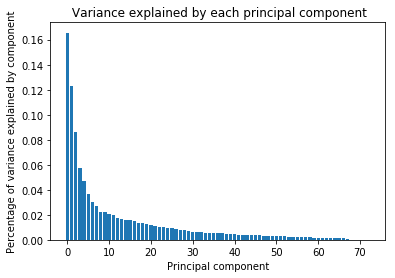

In [11]:
### Plotting variance by component
variance_plot(pca)

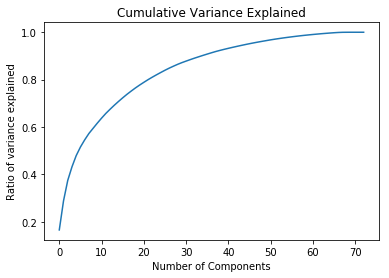

In [12]:
### Plotting cumulative variance by component
variance_cumsum_plot(pca)

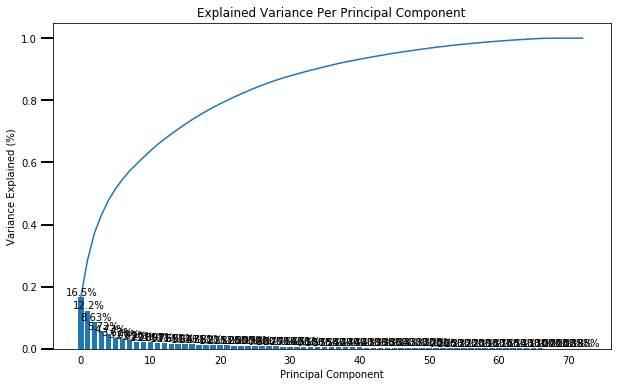

In [13]:
### Combining both plots
scree_plot(pca)

In [14]:
### Components explain about 90% of variance
variance_array = np.cumsum(pca.explained_variance_ratio_)
var_90 = []

print('Printing the cumulative variance')
for i in variance_array:
    print(i)
    var_90.append(i)
    if(i > 0.9):
        break   

print('\n{} components explain {} of the total variance'.format(len(var_90), var_90[-1]))     

Printing the cumulative variance
0.165539359854
0.288229312468
0.374598507704
0.431815569298
0.479164380907
0.515387922134
0.545478804748
0.572455838314
0.594542074933
0.616430107332
0.637331097907
0.657104161245
0.674729792848
0.69165130974
0.707712293965
0.723142408214
0.737843289364
0.751531575444
0.764735328505
0.777008970002
0.788604326779
0.799827869093
0.810360628303
0.820380117331
0.830098321609
0.839551089296
0.848445394356
0.856651037748
0.864564701518
0.871741680199
0.878218985758
0.8845814518
0.890746542505
0.896558427232
0.902323469662

35 components explain 0.9023234696619519 of the total variance


In [111]:
### Re-apply PCA to the data while selecting for number of components to retain.
pca, azdias_pca = do_pca(35, azdias_cleansed)

### Converting the matrix into a DataFrame
df_azdias_pca = pd.DataFrame(azdias_pca)

In [112]:
azdias_cleansed.shape

(891221, 73)

In [113]:
df_azdias_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,2.822601,-2.324359,-3.142463,-3.828162,2.638415,0.856164,0.621552,-0.176866,0.011895,-0.498179,...,0.793687,-0.708091,0.015049,0.327363,-0.035521,0.312655,0.302611,-0.195354,-0.045435,0.067376
1,3.621467,-2.983211,-1.220375,1.688070,-1.290339,-0.068818,1.286402,3.306010,0.737540,-0.782638,...,-0.756701,0.310676,0.254569,0.297492,0.576394,-0.642545,0.253632,-0.148454,0.623249,1.180820
2,-0.961369,-0.324884,-2.165331,3.009530,0.687170,-3.218094,-1.202946,0.024625,0.195677,-0.008044,...,-1.242587,-0.828730,-0.837189,0.637805,0.576699,-0.350513,0.393038,0.628267,-0.290337,-1.027427
3,-4.113166,1.135842,-1.243529,-0.830724,-1.640768,-1.648824,0.382142,-1.279294,-0.024627,0.945998,...,0.024270,1.500322,-0.547743,1.045272,0.346717,-0.540923,0.728141,-0.177394,-0.059960,0.623698
4,-0.452165,1.356228,3.574423,0.512905,1.084452,3.504773,-2.622347,0.109571,1.599461,-1.012347,...,-0.054298,0.178171,-1.170209,0.077775,-0.071466,-0.774448,-0.776447,-0.315588,-0.628398,-0.067820


### Discussion 2.2: Perform Dimensionality Reduction

35 principal components have been retained, as they explain about 90% of the entire variance, while reducing the number of features by more than 50%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [16]:
### Checking pca components
print(pca.components_.shape)

(35, 73)


In [114]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

### Creating the weights function
def pca_weights(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(azdias_cleansed.columns))
    component_weights = df.iloc[i].sort_values(ascending=False)
    return component_weights

In [116]:
### Mapping weights for the first principal component to corresponding feature names
first_component_weights = pca_weights(pca, 0)
print(first_component_weights)

PLZ8_ANTG3                  0.212194
Household                   0.203760
CAMEO_INTL_2015             0.200124
EWDICHTE                    0.188459
PLZ8_BAUMAX                 0.177560
ORTSGR_KLS9                 0.173338
PLZ8_ANTG4                  0.167235
FINANZ_SPARER               0.149795
PLZ8_ANTG2                  0.144542
ARBEIT                      0.141895
FINANZ_HAUSBAUER            0.138636
HH_EINKOMMEN_SCORE          0.135888
KBA05_ANTG4                 0.125433
SEMIO_REL                   0.119822
RELAT_AB                    0.119399
Decade                      0.119054
PRAEGENDE_JUGENDJAHRE       0.114093
SEMIO_PFLICHT               0.113527
ANZ_HAUSHALTE_AKTIV         0.108632
KBA05_ANTG3                 0.104801
FINANZ_UNAUFFAELLIGER       0.098955
FINANZ_ANLEGER              0.092739
SEMIO_RAT                   0.090863
SEMIO_FAM                   0.080023
SEMIO_MAT                   0.079918
number_of_missing_values    0.073321
REGIOTYP                    0.070499
S

In [19]:
### Mapping weights for the second principal component to corresponding feature names
second_component_weights = pca_weights(pca, 1)
print(second_component_weights)

ALTERSKATEGORIE_GROB        0.241722
FINANZ_VORSORGER            0.228598
SEMIO_ERL                   0.194339
RETOURTYP_BK_S              0.164096
SEMIO_LUST                  0.160114
PLZ8_ANTG4                  0.132163
PLZ8_BAUMAX                 0.124817
FINANZ_HAUSBAUER            0.120368
ORTSGR_KLS9                 0.110958
PLZ8_ANTG3                  0.099846
KBA05_ANTG4                 0.093018
HH_EINKOMMEN_SCORE          0.092502
W_KEIT_KIND_HH              0.090825
ANZ_HAUSHALTE_AKTIV         0.084843
RELAT_AB                    0.075993
KBA05_ANTG3                 0.070189
EWDICHTE                    0.069837
PLZ8_ANTG2                  0.069247
FINANZ_MINIMALIST           0.067272
CAMEO_INTL_2015             0.058404
ARBEIT                      0.054561
Household                   0.052886
Number_of_People            0.050370
WOHNDAUER_2008              0.040206
ANZ_HH_TITEL                0.037735
SEMIO_KAEM                  0.033067
PLZ8_HHZ                    0.032902
A

In [20]:
### Mapping weights for the third principal component to corresponding feature names
third_component_weights = pca_weights(pca, 2)
print(third_component_weights)

SEMIO_VERT                  0.334487
SEMIO_KULT                  0.305558
SEMIO_SOZ                   0.299593
SEMIO_FAM                   0.219239
PLZ8_ANTG4                  0.113299
PLZ8_BAUMAX                 0.107310
SEMIO_MAT                   0.089592
SEMIO_REL                   0.078219
Movement                    0.066436
GREEN_AVANTGARDE            0.066436
ORTSGR_KLS9                 0.066068
HH_EINKOMMEN_SCORE          0.065991
SEMIO_TRADV                 0.064989
KBA05_ANTG4                 0.058453
FINANZ_MINIMALIST           0.057680
ANZ_HAUSHALTE_AKTIV         0.057618
ANZ_PERSONEN                0.053667
KBA05_ANTG3                 0.049872
LP_LEBENSPHASE_FEIN         0.047268
KBA05_ANTG2                 0.046697
Life_Stage                  0.042762
ONLINE_AFFINITAET           0.036526
LP_LEBENSPHASE_GROB         0.036403
PLZ8_HHZ                    0.036377
PLZ8_ANTG3                  0.035428
RELAT_AB                    0.035059
MOBI_REGIO                  0.034435
R

## Discussion 2.3: Interpret Principal Components

### First principal component analysis

Number of 6-10 family houses in the PLZ8 region, household and Wealth/Life Stage Typology have the highest positive weight values. It makes sense that they are all positevely correalated and explain the variation of the first principal component. We can assume that, the bigger the family in this this specific region, the wealthier and more prosperous the household is and add this customers to a specific cluster.


Number of 1-2 family houses in the microcell, Number of 1-2 family houses in the PLZ8 region and Movement patterns have the highest negative weight values. Again, based on the previous assumption, the smaller the family in this specific region, the poorer the household is and a customer with this profile is supposed to be part of a different cluster. 



**Positive coeficients**

PLZ8_ANTG3: 0.212194
<br/>
Household : 0.203760
<br/>
CAMEO_INTL_2015: 0.200124


**Negative coeficients**

KBA05_ANTG1: -0.204421
<br/>
PLZ8_ANTG1:  -0.210613
<br/>
MOBI_REGIO:  -0.213563

### Dictionary

#### 8.4. PLZ8_ANTG3
Number of 6-10 family houses in the PLZ8 region
- -1: unknown
-  0: no 6-10 family homes
-  1: lower share of 6-10 family homes
-  2: average share of 6-10 family homes
-  3: high share of 6-10 family homes


#### Household
###Creating a household dictionary
- 0: Wealthy
- 1: Prosperous
- 2: Comfortable
- 3: Less Affluent
- 4: Poorer

#### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


#### 5.1. KBA05_ANTG1
Number of 1-2 family houses in the microcell
- -1: unknown
-  0: no 1-2 family homes
-  1: lower share of 1-2 family homes
-  2: average share of 1-2 family homes
-  3: high share of 1-2 family homes
-  4: very high share of 1-2 family homes


#### 8.2. PLZ8_ANTG1
Number of 1-2 family houses in the PLZ8 region
- -1: unknown
-  0: no 1-2 family homes
-  1: lower share of 1-2 family homes
-  2: average share of 1-2 family homes
-  3: high share of 1-2 family homes
-  4: very high share of 1-2 family homes


#### 7.3. MOBI_REGIO
Movement patterns
- 1: very high movement
- 2: high movement
- 3: middle movement
- 4: low movement
- 5: very low movement
- 6: none

---------------------------------------------------------------------------------------------------------------------------

## Second principal component analysis

Estimated age based on given name analysis and Financial typology for "be prepared" type of customer have the highest positive weight values and help explain the positive variation of the second Principal Componenent. We could assume that age and financial topology are supposed to be positevely correlated and say a lot about a customer.


Decade and Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west) have the highest negative weight values. Same case. The decade a customer was born and the dominating movement of his/her youth say a lot about his profile. It makes sense that these two groups of variables describe different types of customer, who will eventually be part of a different clusters.


**Positive coeficients**

ALTERSKATEGORIE_GROB: 0.241722
<br/>
FINANZ_VORSORGER: 0.228598


**Negative coeficients**

Decade: -0.253332
<br/>
PRAEGENDE_JUGENDJAHRE: -0.255533


### Dictionary

#### 1.2. ALTERSKATEGORIE_GROB
Estimated age based on given name analysis
- -1: unknown (missing)
-  0: unknown (cannot be determined)
-  1: < 30 years old
-  2: 30 - 45 years old
-  3: 46 - 60 years old
-  4: > 60 years old
-  9: uniformly distributed



#### 1.5. FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_VORSORGER, FINANZ_ANLEGER, FINANZ_UNAUFFAELLIGER, 
#### FINANZ_HAUSBAUER
Financial typology, for each dimension:
- -1: unknown
-  1: very high
-  2: high
-  3: average
-  4: low
-  5: very low

Dimension translations:
- MINIMALIST: low financial interest
- SPARER: money-saver
- VORSORGER: be prepared
- ANLEGER: investor
- UNAUFFAELLIGER: inconspicuous
- HAUSBAUER: home ownership


#### Decade
- 0:1940s
- 1:1950s 
- 2:1960s
- 3:1970s,
- 4:1980s,
- 5:1990s


#### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

---------------------------------------------------------------------------------------------------------------------------

## Third principal component analysis


The dimensions: dreamful, cultural-minded, socially-minded, family-minded have the highest positive weight values and help explain the positive variation of the third Principal Componenent. It makes sense that all of them have high positive coefficients. Someone who has a high affinity in each of these dimensions can be resonably part of a specific cluster. In addition, someone who has a low affinity in each of these dimensions is very likely to be part of a different cluster.


The variable gender, the dimensions dominant-minded, critical-minded and combative attitude have the highest negative weight values and help explain the negative variation of the third Principal Componenent. Again, a customer who has a high affinity in each of these dimensions and belongs to a specific gender has a specific profile. Besides, this profile can be considered very different from that previously mentioned and the customers who have this profile should be part of a separate cluster.


**Positive coeficients**

SEMIO_VERT: 0.334487
<br/>
SEMIO_KULT: 0.305558
<br/>
SEMIO_SOZ:  0.299594
<br/>
SEMIO_FAM:  0.219239


**Negative coeficients**

SEMIO_DOM:  -0.298565
<br/>
ANREDE_KZ:  -0.311277
<br/>
SEMIO_KRIT: -0.315249
<br/>
SEMIO_KAEM: -0.331421


## Dictionary

#### SEMIO_VERT
- VERT: dreamful

#### SEMIO_KULT
- KULT: cultural-minded

#### SEMIO_SOZ
- SOZ: socially-minded

#### SEMIO_FAM
- FAM: family-minded

#### SEMIO_DOM
- DOM: dominant-minded

#### 1.3. ANREDE_KZ
Gender
- -1: unknown (missing)
-  0: unknown (cannot be determined)
-  1: male
-  2: female

#### SEMIO_KRIT
- KRIT: critical-minded

#### SEMIO_KAEM
- KAEM: combative attitude


#### 1.20. SEMIO_SOZ, SEMIO_FAM, SEMIO_REL, SEMIO_MAT, SEMIO_VERT, SEMIO_LUST,
####       SEMIO_ERL, SEMIO_KULT, SEMIO_RAT, SEMIO_KRIT, SEMIO_DOM, SEMIO_KAEM,
####       SEMIO_PFLICHT, SEMIO_TRADV
Personality typology, for each dimension:
- -1: unknown
-  1: highest affinity
-  2: very high affinity
-  3: high affinity
-  4: average affinity
-  5: low affinity
-  6: very low affinity
-  7: lowest affinity
-  9: unknown


Dimension translations:
- SOZ: socially-minded
- FAM: family-minded
- REL: religious
- MAT: materialistic
- VERT: dreamful
- LUST: sensual-minded
- ERL: event-oriented
- KULT: cultural-minded
- RAT: rational
- KRIT: critical-minded
- DOM: dominant-minded
- KAEM: combative attitude
- PFLICHT: dutiful
- TRADV: tradional-minded

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [46]:
def k_mean_score(df, n):
    kmeans = KMeans(n_clusters = n)
    model = kmeans.fit(df)
    score = np.abs(model.score(df))
    return score

In [55]:
### Running k-means clustering on the data and computing the average within-cluster distances
cluster_count = list(range(1, 32, 5))
scores = []

for n in cluster_count:
    score_n = k_mean_score(azdias_pca, n)
    scores.append(score_n) 

df_scores = pd.DataFrame({'Number of Clusters': cluster_count, 'Score': scores})
print(df_scores)

   Number of Clusters         Score
0                   1  5.869570e+07
1                   6  3.949851e+07
2                  11  3.444157e+07
3                  16  3.166676e+07
4                  21  3.000541e+07
5                  26  2.877877e+07
6                  31  2.748998e+07


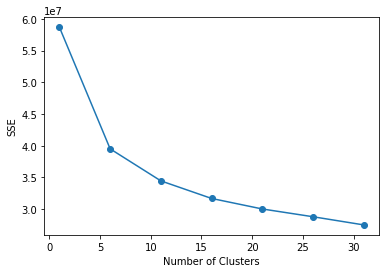

In [57]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(cluster_count, scores, linestyle='-', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

In [76]:
### Narrowing the number of clusters
cluster_count = list(range(20, 31, 1))
scores = []


for n in cluster_count:
    score_n = k_mean_score(azdias_pca, n)
    scores.append(score_n) 

df_scores = pd.DataFrame({'Number of Clusters': cluster_count, 'Score': scores})
print(df_scores)

    Number of Clusters         Score
0                   20  3.059663e+07
1                   21  3.008715e+07
2                   22  2.972826e+07
3                   23  2.938927e+07
4                   24  2.895749e+07
5                   25  2.898080e+07
6                   26  2.851736e+07
7                   27  2.826732e+07
8                   28  2.804958e+07
9                   29  2.786481e+07
10                  30  2.764006e+07


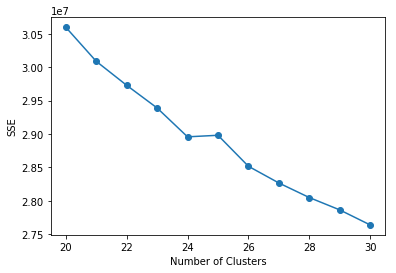

In [77]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(cluster_count, scores, linestyle='-', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

In [62]:
### Re-fit the k-means model with the selected number of clusters and obtain cluster predictions
##for the general population demographics data.
kmeans = KMeans(n_clusters=25)
model_n = kmeans.fit(azdias_pca)
azdias_pred = model_n.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

The first plot showed that the elbow happens when k is between 25 and 30. Moreover, we can check the scores for each number of clusters and realize that the difference between the scores keeps getting smaller as k is greater than 16

When we narrowed down the range of number of clusters, we can see that the elbow happens when k = 25. So, the number of clusters to be selected is 25

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

### Identifing missing or unknown data values and converting them to NaNs
Total number of missing values 2252274

### Number of missing values by column
ALTER_HH                46596
ANZ_HAUSHALTE_AKTIV     49927
ANZ_HH_TITEL            52110
ANZ_PERSONEN            46596
ANZ_TITEL               46596
ARBEIT                  50476
BALLRAUM                49959
CAMEO_DEUG_2015         50428
CAMEO_DEU_2015          50428
CAMEO_INTL_2015         50428
CJT_GESAMTTYP            3213
EWDICHTE                49959
GEBAEUDETYP             49927
GEBAEUDETYP_RASTER      49927
GFK_URLAUBERTYP          3213
HH_EINKOMMEN_SCORE       2968
INNENSTADT              49959
KBA05_ANTG1             55980
KBA05_ANTG2             55980
KBA05_ANTG3             55980
KBA05_ANTG4             55980
KBA05_BAUMAX            55980
KBA05_GBZ               55980
KBA13_ANZAHL_PKW        51281
KKK                     54260
KK_KUNDENTYP           111937
KONSUMNAEHE             46651
LP_FAMILIE_FEIN          3213
LP_FAMI

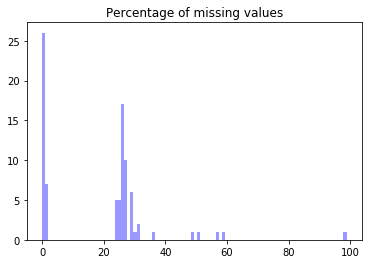


### Revoving columns whose percentage of missing values is greater then 30%
This is the list of columns to be dropped: ['TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'AGER_TYP', 'GEBURTSJAHR', 'ALTER_HH', 'REGIOTYP', 'KKK']
Columns dropped!

### Assessing Missing Data in Each Row
Missing rows by number
13188     45
22535     45
128189    45
133494    44
133507    44
133506    44
133505    44
133504    44
133503    44
133502    44
133501    44
133500    44
133499    44
133498    44
133496    44
133495    44
95825     44
133509    44
133493    44
133492    44
133491    44
133490    44
133488    44
133487    44
133486    44
133485    44
133484    44
133483    44
133482    44
133481    44
          ..
113545     0
113544     0
113543     0
113541     0
113553     0
113540     0
113498     0
113491     0
113474     0
113460     0
113444     0
113551     0
113555     0
113575     0
113567     0
113574     0
113573     0
113572     0
113571     0
113570     0
113568     0
113566     0
113556  

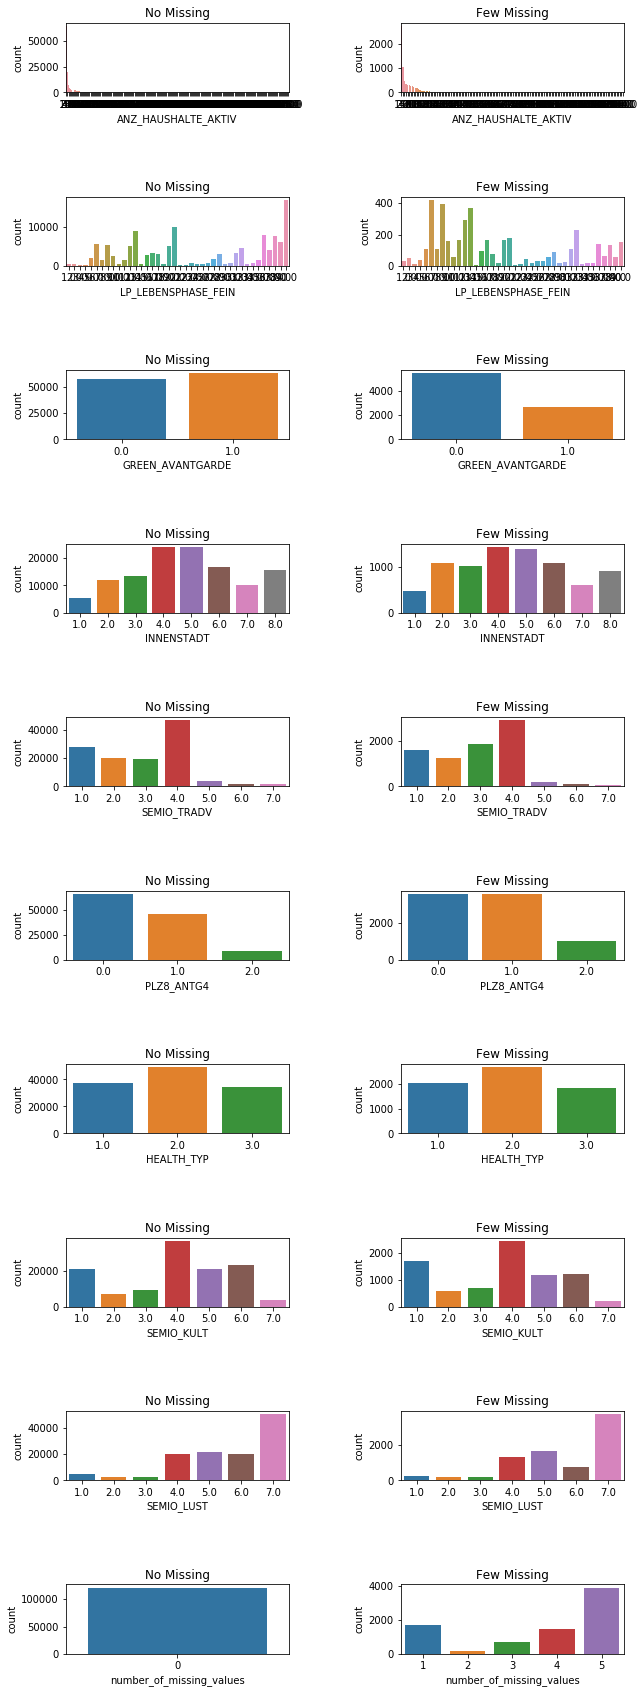


 ### Removing the columns with many missing values from the attributes table
### Checking the number of features for each type
### Getting the list of categorical features
['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
### Assesing categorical variables

ANREDE_KZ
[ 1.  2.]
2
CJT_GESAMTTYP
[  5.  nan   2.   6.   4.   1.   3.]
7
FINANZTYP
[ 2.  6.  5.  3.  1.  4.]
6
GFK_URLAUBERTYP
[  4.  nan   3.  10.   2.  11.   8.   1.   5.   9.  12.   7.   6.]
13
GREEN_AVANTGARDE
[ 1.  0.]
2
LP_FAMILIE_FEIN
[  2.  nan   1.  10.   8.   6.  11.   9.   7.   5.   3.   4.]
12
LP_FAMILIE_GROB
[  2.  nan   1.   5.   4.   3.]
6
LP_STATUS_FEIN
[ 10.  nan   9.   1.   7.   6.   3.   5.   8.   4.   2.]
11
LP_STATUS_GROB
[  5.  nan   4.   1.   3.   2.]
6
NATIONALITAET_

In [78]:
### Loading in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
### Loading in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

### Calling the cleaning function
customers_cleansed = clean_data(customers, feat_info)

In [79]:
customers_cleansed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ARBEIT,ORTSGR_KLS9,RELAT_AB,number_of_missing_values,Decade,Movement,Household,Life_Stage,Construction_Type,Number_of_People
0,0.886637,-0.776965,1.000000,-0.801149,0.820488,-0.847979,-0.407296,-0.680853,1.312832,-1.445365,...,-2.150334,-1.665697,-1.577416,-0.639587,-0.540031,1.312832,-1.166706,-0.449693,0.236725,-0.210912
1,0.886637,-0.776965,1.000000,-0.801149,0.820488,-0.847979,0.223021,-0.680853,-0.761712,-1.445365,...,0.149169,-0.047489,0.061867,1.625720,-0.540031,-0.761712,-0.356585,0.394228,0.236725,-0.210912
2,0.886637,1.287059,1.000000,-0.801149,0.820488,-0.847979,0.853339,1.062295,1.312832,0.052027,...,0.149169,-0.047489,0.061867,-0.639587,-0.540031,1.312832,0.453536,0.394228,0.236725,2.844857
3,0.886637,-0.776965,1.000000,-0.801149,0.820488,-0.259026,-1.037614,-0.680853,-0.761712,0.052027,...,-2.150334,-1.126294,-1.577416,-0.262036,-1.355862,-0.761712,-0.356585,0.394228,0.236725,-0.210912
4,-0.051252,-0.776965,-0.930079,-0.801149,-0.184171,0.918880,1.483656,-0.680853,-0.761712,1.549419,...,0.149169,-0.047489,-1.577416,-0.639587,1.091632,-0.761712,1.263657,-2.137533,0.236725,1.316972


In [105]:
### PCA transformation
pca_c, customers_pca = do_pca(35, customers_cleansed)

In [106]:
### Predicting using Kmeans model_n
customers_pred = model_n.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

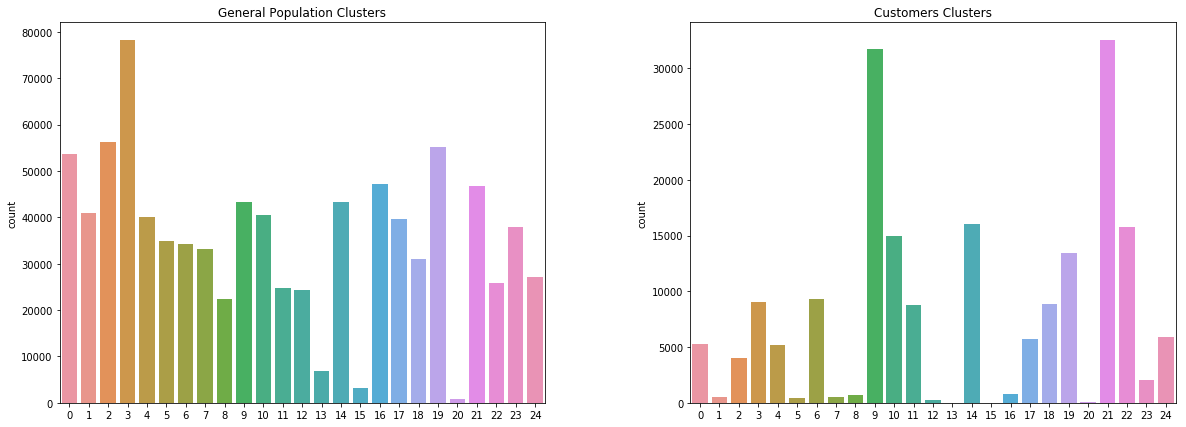

In [87]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (20,7))
figure.subplots_adjust(hspace = 3, wspace=.3)

### Plotting general population
sns.countplot(azdias_pred, ax=axs[0])
axs[0].set_title('General Population Clusters')

### Plotting customer population
sns.countplot(customers_pred, ax=axs[1])
axs[1].set_title('Customers Clusters')
plt.show()

In [100]:
### What kinds of people are part of a cluster that is overrepresented in the customer data
### compared to the general population?

### Editing the weights function to the customer population
def pca_weights_customers(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(customers_cleansed.columns))
    component_weights = df.iloc[i].sort_values(ascending=False)
    return component_weights

In [107]:
### Mapping weights for the first principal component to corresponding feature names

### Cluster 9 is overrepresented in the customer data
Overrep_component_weights = pca_weights_customers(pca_c, 9)
print(Overrep_component_weights)

Construction_Type        0.458343
Number_of_People         0.375749
ANZ_HH_TITEL             0.323796
ANZ_HAUSHALTE_AKTIV      0.300001
GEBAEUDETYP_RASTER       0.168746
ARBEIT                   0.134332
PLZ8_GBZ                 0.128688
PRAEGENDE_JUGENDJAHRE    0.124637
Decade                   0.120714
Life_Stage               0.118099
KBA05_ANTG4              0.110553
KONSUMNAEHE              0.108669
KBA13_ANZAHL_PKW         0.104515
PLZ8_HHZ                 0.101992
RELAT_AB                 0.090246
HH_EINKOMMEN_SCORE       0.089725
ANZ_TITEL                0.087933
FINANZ_SPARER            0.079482
CAMEO_INTL_2015          0.073225
Household                0.072828
MIN_GEBAEUDEJAHR         0.068049
ORTSGR_KLS9              0.065205
PLZ8_ANTG1               0.061792
FINANZ_ANLEGER           0.059972
FINANZ_UNAUFFAELLIGER    0.059593
ALTERSKATEGORIE_GROB     0.050999
ONLINE_AFFINITAET        0.047628
EWDICHTE                 0.044298
SEMIO_LUST               0.042249
ANZ_PERSONEN  

In [108]:
### What kinds of people are part of a cluster that is underrepresented in the customer data 
### compared to the general population?

### Cluster 3 is underrepresented in the customer data
underrep_component_weights = pca_weights_customers(pca_c, 3)
print(underrep_component_weights)

Decade                      0.353974
PRAEGENDE_JUGENDJAHRE       0.325896
WOHNLAGE                    0.218394
HEALTH_TYP                  0.193179
SEMIO_RAT                   0.181548
HH_EINKOMMEN_SCORE          0.164184
ONLINE_AFFINITAET           0.157930
SEMIO_TRADV                 0.147821
VERS_TYP                    0.143061
INNENSTADT                  0.129544
ANREDE_KZ                   0.121946
MIN_GEBAEUDEJAHR            0.116984
SEMIO_ERL                   0.113139
CAMEO_INTL_2015             0.107490
SEMIO_KAEM                  0.100547
SEMIO_PFLICHT               0.093066
Household                   0.092236
SEMIO_DOM                   0.082680
FINANZ_ANLEGER              0.075483
BALLRAUM                    0.074440
FINANZ_SPARER               0.071454
KONSUMNAEHE                 0.064806
KBA05_ANTG4                 0.063742
KBA05_ANTG3                 0.061353
ANZ_PERSONEN                0.056102
PLZ8_ANTG1                  0.048006
ANZ_HAUSHALTE_AKTIV         0.044714
K

### Discussion 3.3: Compare Customer Data to Demographics Data

#### Overrepresented component - People from Cluster 9

A huge chunk of customers belong to Cluster 9 whereas it doesn't have the same proportion in the general population. 

People who have the following characteristics are part of this cluster, which it is not a relevant part of the general population.

- belong to small families
- live in a residence in a residencial area
- don't have to share the area they live with other people
- have healthy issues
- length of residence less than 1 year
- have a tradional mind
- live in mainly 1-2 family homes in the PLZ8 region


**Positive coeficients**

Construction_Type: 0.458342
<br/>
Number_of_People: 0.375756
<br/>
ANZ_HH_TITEL: 0.323855
<br/>
ANZ_HAUSHALTE_AKTIV: 0.299928
<br/>
GEBAEUDETYP_RASTER:0.168757


**Negative coeficients**

HEALTH_TYP: -0.140206
<br/>
WOHNDAUER_2008: -0.144780
<br/>
SEMIO_TRADV: -0.145260
<br/>
PLZ8_BAUMAX: -0.257599


#### Underrepresented component - People from Cluster 3

Cluster 3 is the most popular cluster in the general population and it is not even close to the top when it comes to the customer population.

People who have the following characteristics are part of this cluster, which represent a big part of the population.
- older
- born in the war years
- live in a very good neighbourhood
- healthy
- with a big family
- a rational mind
- live in a small community
- are sensual minded
- live in a place with less than 34 households per km^2 



**Positive coeficients**

Decade: 0.353975
<br/>
PRAEGENDE_JUGENDJAHRE: 0.325896
<br/>
WOHNLAGE: 0.218394
<br/>
HEALTH_TYP: 0.193179
<br/>
SEMIO_RAT: 0.181548


**Negative coeficients**

ORTSGR_KLS9: -0.175610
<br/>
W_KEIT_KIND_HH: -0.202370
<br/>
SEMIO_LUST: -0.208927
<br/>
EWDICHTE: -0.212612

------------------------------------------------------------------------------------------------------------------------------


### Overrepresented variables


#### Creating a construction_type dictionary 
- 0: Business building
- 1: Family home
	
	
#### Creating a number of people living
- 0: 0 people
- 1: mainly 1-2 family homes
- 2: mainly 3-5 family homes
- 3: mainly 6-10 family homes
- 4: mainly 10+ family homes	


#### 3.2. ANZ_HH_TITEL
Number of professional academic title holders in building


#### 3.1. ANZ_HAUSHALTE_AKTIV
Number of households in the building
- missing values encoded by 0


#### 7.1. GEBAEUDETYP_RASTER
Ratio of residential to commercial activity
- 1: business cell
- 2: mixed cell with high business share
- 3: mixed cell with middle business share
- 4: mixed cell with low business share
- 5: residential cell


#### 1.10. HEALTH_TYP
Health typology
- -1: unknown
-  0: classification not possible
-  1: critical reserved
-  2: sanitary affine  
-  3: jaunty hedonists


#### 2.7. WOHNDAUER_2008
Length of residence
- -1: unknown
-  0: unknown
-  1: length of residence less than 1 year
-  2: length of residence 1-2 years
-  3: length of residence 2-3 years
-  4: length of residence 3-4 years
-  5: length of residence 4-5 years
-  6: length of residence 5-6 years
-  7: length of residence 6-7 years
-  8: length of residence 7-10 years
-  9: length of residence more than 10 years


#### 1.20. SEMIO_TRADV
Personality typology, for each dimension:
- -1: unknown
-  1: highest affinity
-  2: very high affinity
-  3: high affinity
-  4: average affinity
-  5: low affinity
-  6: very low affinity
-  7: lowest affinity
-  9: unknown

Dimension translations:
- TRADV: tradional-minded


### 8.6. PLZ8_BAUMAX
Most common building type within the PLZ8 region
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes
-  2: mainly 3-5 family homes
-  3: mainly 6-10 family homes
-  4: mainly 10+ family homes
-  5: mainly business buildings


-----------------------------------------------------------------------------------------------------------------------------

### Underrepresented variables

#### decade
- 0:1940s
- 1:1950s
- 2:1960s
- 3:1970s
- 4:1980s
- 5:1990s


#### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)


#### 3.7. WOHNLAGE
Neighborhood quality (or rural flag)
- -1: unknown
-  0: no score calculated
-  1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7: rural neighborhood
-  8: new building in rural neighborhood


#### 1.10. HEALTH_TYP
Health typology
- -1: unknown
-  0: classification not possible
-  1: critical reserved
-  2: sanitary affine  
-  3: jaunty hedonists


#### 1.20. SEMIO_RAT
Personality typology, for each dimension:
- -1: unknown
-  1: highest affinity
-  2: very high affinity
-  3: high affinity
-  4: average affinity
-  5: low affinity
-  6: very low affinity
-  7: lowest affinity
-  9: unknown

Dimension translations:
- SOZ: socially-minded
- FAM: family-minded
- REL: religious
- MAT: materialistic
- VERT: dreamful
- LUST: sensual-minded
- ERL: event-oriented
- KULT: cultural-minded
- RAT: rational
- KRIT: critical-minded
- DOM: dominant-minded
- KAEM: combative attitude
- PFLICHT: dutiful
- TRADV: tradional-minded


#### 9.2. ORTSGR_KLS9
Size of community
- -1: unknown
-  1: <= 2,000 inhabitants
-  2:   2,001 to   5,000 inhabitants
-  3:   5,001 to  10,000 inhabitants
-  4:  10,001 to  20,000 inhabitants
-  5:  20,001 to  50,000 inhabitants
-  6:  50,001 to 100,000 inhabitants
-  7: 100,001 to 300,000 inhabitants
-  8: 300,001 to 700,000 inhabitants
-  9: > 700,000  inhabitants


#### 2.6. W_KEIT_KIND_HH
Likelihood of children in household
- -1: unknown
-  0: unknown
-  1: most likely
-  2: very likely
-  3: likely
-  4: average
-  5: unlikely
-  6: very unlikely


#### 1.20. SEMIO_LUST,
Personality typology, for each dimension:
- -1: unknown
-  1: highest affinity
-  2: very high affinity
-  3: high affinity
-  4: average affinity
-  5: low affinity
-  6: very low affinity
-  7: lowest affinity
-  9: unknown

Dimension translations:
- LUST: sensual-minded


#### 6.2. EWDICHTE
Density of households per square kilometer
- -1: unknown
-  1: less than 34 households per km^2
-  2:  34 -  89 households per km^2
-  3:  90 - 149 households per km^2
-  4: 150 - 319 households per km^2
-  5: 320 - 999 households per km^2
-  6: more than 999 households per km^2

In [ ]:
###Can we describe segments of the population that are relatively popular with the mail-order company,
###or relatively unpopular with the company?

### Popular segment: Cluster 3 - Weights already displayed and described

In [124]:
### Unpopular segment: Cluster 20
unpop_component_weights = pca_weights(pca, 20)
print(unpop_component_weights)

Household                0.308237
CAMEO_INTL_2015          0.288810
ANZ_TITEL                0.194041
RETOURTYP_BK_S           0.132827
Construction_Type        0.123435
Movement                 0.115005
GREEN_AVANTGARDE         0.115005
WOHNLAGE                 0.108557
PLZ8_ANTG1               0.084151
HEALTH_TYP               0.069300
HH_EINKOMMEN_SCORE       0.063996
KBA05_GBZ                0.063862
KBA13_ANZAHL_PKW         0.061448
ORTSGR_KLS9              0.057757
EWDICHTE                 0.054106
ONLINE_AFFINITAET        0.051659
PLZ8_GBZ                 0.042958
Number_of_People         0.041383
KONSUMNAEHE              0.040707
MOBI_REGIO               0.038566
KBA05_ANTG3              0.035855
FINANZ_MINIMALIST        0.034634
KBA05_ANTG2              0.030509
SOHO_KZ                  0.023427
SEMIO_DOM                0.017219
SEMIO_MAT                0.017021
SEMIO_KAEM               0.013054
PRAEGENDE_JUGENDJAHRE    0.012559
GEBAEUDETYP_RASTER       0.009165
KBA05_ANTG1   

### Comments

#### Popular segment
As we mentioned before, cluster 3 is the most popular cluster in the general population and its customers have already been described. 


#### Unpopular segment

Based on the weights and on the dictionary values, customers who are part of Cluster 20 are a not a numerous segment in neither the general population nor among customers.  


The following variables have the highest positive weight values and help explain the positive variation of this Principal Componenent. People who have the following characteristics are part of this cluster:

- wealthy
- part of a family whose members hold professional academic titles
- Crazy-Shopper
- live with his family in a residence.

To finish, based on the variables that have highest negative weight values, we can assume that, a typical person from this cluster also has the following characteristics:

- lives in city center
- in Eastern Germany
- less than 10 Km to nearest urban center
- is single
- lives in place whose unemployment rates is low

This specific cluster is not a relevant fraction of the customers and should be left aside. At least for now.


**Positive coeficients**

Household: 0.308237
<br/>
CAMEO_INTL_2015: 0.288810
<br/>
ANZ_TITEL: 0.194041
<br/>
RETOURTYP_BK_S: 0.132827
<br/>
Construction_Type: 0.123435


**Negative coeficients**

INNENSTADT: -0.272458
<br/>
OST_WEST_KZ: -0.274146
<br/>
BALLRAUM: -0.288680
<br/>
Life_Stage: -0.331511
<br/>
RELAT_AB: -0.369706

----------------------------------------------------------------------------------------------------------------------------

#### Household
- 0: Wealthy
- 1: Prosperous
- 2: Comfortable
- 3: Less Affluent
- 4: Poorer


#### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


#### 2.3. ANZ_TITEL
Number of professional academic title holders in household


#### 1.19. RETOURTYP_BK_S
Return type
- 0: unknown
- 1: influenceable Crazy-Shopper
- 2: demanding Heavy-Returner
- 3: incentive-receptive Normal-Returner
- 4: conservative Low-Returner
- 5: determined Minimal-Returner


#### construction_type
- 0: Business building
- 1: Family home


#### 6.3. INNENSTADT
Distance to city center (downtown)
- -1: unknown
-  1: in city center
-  2: less than 3 km to city center
-  3:  3 -  5 km to city center
-  4:  5 - 10 km to city center
-  5: 10 - 20 km to city center
-  6: 20 - 30 km to city center
-  7: 30 - 40 km to city center
-  8: more than 40 km to city center


#### 3.6. OST_WEST_KZ
Building location via former East / West Germany (GDR / FRG)
- -1: unknown
-  O: East (GDR)
-  W: West (FRG)


#### 6.1. BALLRAUM
Distance to nearest urban center
- -1: unknown
-  1: less than 10 km
-  2: 10 -  20 km
-  3: 20 -  30 km
-  4: 30 -  40 km
-  5: 40 -  50 km
-  6: 50 - 100 km
-  7: more than 100 km


#### Life Stage
- 0: Pre-Family Couples & Singles
- 1: Young Couples With Children
- 2: Families With School Age Children
- 3: Older Families & Mature Couples
 - 4: Elders In Retirement
 
 
#### 9.3. RELAT_AB
Share of unemployment relative to county in which community is contained
- -1: unknown
-  1: very low
-  2: low
-  3: average
-  4: high
-  5: very high
-  9: unknown

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.